# This notebook compiles the Fish Island Data and Post-processes it

In [44]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib notebook
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor as MPR
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from scipy.optimize import curve_fit
from matplotlib.ticker import NullFormatter
import Data_Processor as DP
import importlib
importlib.reload(DP)

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

Root = 'C:/FishIsland_2017/'
FluxFolder='FluxResults/Test/'
TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2020-08-20T121146_exp.csv'
# TenHz_Path = Root+FluxFolder+'Downsampled/eddypro_DownSampled_full_output_2021-06-10T115019_exp.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2020-08-20T183544_exp.csv'
Met_Path = Root+'MetStationData/CR1000_ClimateData.txt'
Soil_Path = Root+'SoilStationData/Soil_Data.csv'
Taglu_Data = Root+'TagluStationData/Hourly_Data.csv'
Daytime = 'Daytime.csv'
NARRData = Root+'NARRData2.csv'
Comp = DP.Compile([TenHz_Path,OneHz_Path],Met_Path,Soil_Path,Daytime,Taglu_Data,NARRData,
                  Drop_Variables = ['daytime','none_flux','qc_none_flux','none_v-adv','none_molar_density',
                    'none_mole_fraction' ,'none_mixing_ratio','none_time_lag','none_spikes',
                    'none_var','w/none_cov','x_peak','x_offset','x_10%','x_30%','x_50%','x_70%','x_90%'])
Drop = [#['2017-06-01 15:00:00','2017-06-22 23:30:00'],
['2017-07-10 10:00:00','2017-07-10 15:00:00'],
['2017-07-12 12:0:00','2017-07-12 14:00:00'],
['2017-08-01 10:00:00','2017-08-01 14:00:00'],
['2017-08-21 11:00:00','2017-08-21 14:00:00'],
['2017-09-12 07:30:00','2017-09-12 15:00:00']
       ]
# for drop in Drop:
Comp.Date_Drop(Drop,'2017-06-23 00:00:00')#,Vars='All')
    

Comp.StorageCorrection()
Comp.QC_Check(2)
Rm1 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('QC Filter Removal:\n',Rm1)
Comp.Rain_Check([7,0])
Rm2 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('Rain Filter Removal:\n',Rm2-Rm1)
Comp.Signal_Check(20)
Rm3 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('RSSI Filter Removal:\n',Rm3-Rm2)
Comp.Wind_Filter(30,35+180)
Rm4 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('Wind Filter Removal:\n',Rm4-Rm3)
Comp.Spike_Removal(z_thresh=4)
Rm5 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('Spike Filter Removal:\n',Rm5-Rm4)
# Comp.ustar_Bins(30,{'Var':'PPFD_Avg','Thresh':10},{'Var':'co2_flux','Plot':False},
#                 {'Repetitions':100,'n_samples':10000})
# print(Comp.uThresh)
Comp.Ustar_Drop(Override=.1)
Rm6 = 1- Comp.Data[['co2_flux','ch4_flux']].count()/Comp.Data[['co2_raw','ch4_raw']].count().values
print('u* Filter Removal:\n',Rm6-Rm5)
# Comp.Signal_Check(20)
Comp.Wind_Bins(30)
Comp.CustomVars()

# if Taglu_Data is None:

# Comp.Merge(Root)#,Vars,Aliases)


Data = Comp.Data.copy()
Data['Zm'] = 2.87
Data['Z0'] = Data['Zm']*np.exp(-.41*Data['wind_speed']/Data['u*'])
Data.index.name='datetime'

# Comp.AllData['TOD']=Comp.AllData.index.hour+Comp.AllData.index.minute/60
Comp.Data['TOD']=Comp.Data.index.hour+Comp.Data.index.minute/60
#     Vars=['fco2','ER','fch4','SoilMoist(1)','SoilMoist(2)','SoilMoist(4)','Delta_SoilMoist(4)','Total_Rainfall_Tot',
#          'AirTemp_Avg','Net_SW_Wm2_Avg','Net_LW_Wm2_Avg','Net_Ttl_Rad_Avg','WindSpd']
# Data.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AllData.csv')

# Data.to_csv('MostRecent.csv')
Comp.Merge()
print('Final Sample Size')

print(Data[['fco2','fch4']].count())

QC Filter Removal:
 co2_flux    0.045883
ch4_flux    0.108497
dtype: float64
Rain Filter Removal:
 co2_flux    0.000000
ch4_flux    0.002179
dtype: float64
ch4_noSSFilter    2041
ch4_flux          2041
dtype: int64
RSSI Filter Removal:
 co2_flux    0.000000
ch4_flux    0.133333
dtype: float64
Wind Filter Removal:
 co2_flux    0.083281
ch4_flux    0.071895
dtype: float64
Spike Filter Removal:
 co2_flux    0.041169
ch4_flux    0.033115
dtype: float64
u* Filter Removal:
 co2_flux    0.043683
ch4_flux    0.023094
dtype: float64
                      JD  Air Temp  Rainfall  Wind Speed  Wind direction  \
datetime                                                                   
2008-08-28 01:00:00  241       6.0       0.0         3.0           53.88   
2008-08-28 02:00:00  241       5.6       0.0         3.2           56.81   
2008-08-28 03:00:00  241       5.1       0.0         3.2           57.65   
2008-08-28 04:00:00  241       4.7       0.0         2.9           56.24   
2008-08-28 05:

<IPython.core.display.Javascript object>


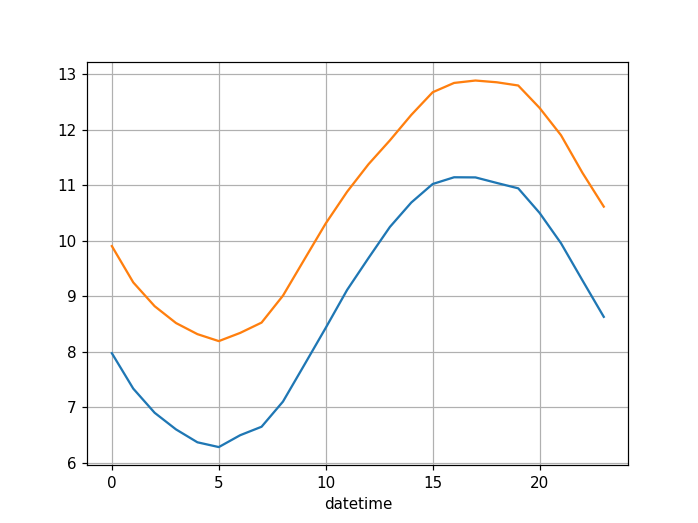

In [45]:
from datetime import datetime

def dateparse(y,m,d,h):
    dt = str(y) + " " + str(m) + " " + str(h) + " " + str(h)#+':00'
    return pd.datetime.strptime(dt, '%Y %m %d %H')
# df = pd.read_csv(infile, parse_dates=['datetime'], date_parser=dateparse)

Data = Comp.dfTaglu

Data = Data.loc[Data.index.year==2017]
Data = Data.loc[Data.index.month>=6]
Data = Data.loc[Data.index.month<=9] 
fig,ax=plt.subplots()
Data.groupby(Data.index.hour).mean()['Air Temp'].plot(ax=ax)
Comp.Data.groupby(Comp.Data.index.hour).mean()['AirTC_Avg'].plot(ax=ax)
ax.grid()
# Data['Time']=((Data['Time']/100-1)).astype(int).astype('str')+':00'
# Data.to_csv(Taglu_Data)
# print(Data.Time)#.astype(int))

# Tagul AWS vs. Fish Island

In [47]:
Satelite=pd.read_csv('SatSun.csv',parse_dates=['Date'])
Satelite=Satelite.set_index(pd.DatetimeIndex(Satelite.Date))
Satelite['Snow'] = Satelite['Snow'].interpolate().bfill()
Satelite=Satelite.drop('DOY',axis=1)
# Satelite_30=Satelite.resample('30T').interpolate()

# GapFilled=pd.read_csv('GapFilled_Fluxes.csv',parse_dates=['datetime'])
# GapFilled=GapFilled.set_index(pd.DatetimeIndex(GapFilled.datetime))

# Taglu = Comp.dfTaglu.loc[((Comp.dfTaglu.index.month > 4)&(Comp.dfTaglu.index.month < 10))].copy()
# print(Taglu.loc[Taglu.index.year==2016].shape)

Taglu = Comp.dfTaglu#.resample('H').asfreq()
# Taglu = Taglu.loc[((Taglu.index.dayofyear >= 100)&(Taglu.index.dayofyear <= 300))].copy()

Taglu['Hour'] = Taglu.index.hour
Taglu['Day'] = Taglu.index.dayofyear
Taglu['Rsmp'] = Taglu['Day']+Taglu['Hour']*.01

Cols = ['Air Temp','Rainfall','Wind Speed','Wind direction',
        'Net SW Radiation','Net LW Radiation ','Net Radiation']
Filler = Taglu.reset_index().groupby('Rsmp').mean()
# print(Filler)
# print(Filler.index)
# Temp = Taglu.loc[Taglu.index.year==2016,['Rsmp']]
# print(Temp[Temp.isin(Filler.index)==False])
# print(Taglu.loc[Taglu.index.year==2016,'Rsmp'])
# Taglu.loc[T]
for c in Cols:
    Nullz = Taglu.loc[Taglu[c].isnull()==True,['Rsmp']]
#     print(Nullz)
    for i,row in Nullz.iterrows():
        Taglu.loc[Taglu.index==i,c]=Filler.loc[Filler.index==row['Rsmp'],c].values[0]
#         print(Taglu.loc[Taglu.index==i,c])#,Filler.loc[Filler.index==row['Rsmp'],c])
#     Taglu.loc[Taglu[c].isnull()==True,c]=Filler.loc[Filler.index.isin(Taglu.loc[Taglu[c].isnull()==True,'Rsmp'].values)]
# for y in range(2009,2019):
# #     for c in Cols:
#     Temp = Taglu.loc[Taglu.index.year==y].copy()#
#     Temp2 = Taglu.loc[Taglu.index.year==y].copy()#
#     print(Temp2.shape,Filler.shape,Temp.shape)
#     for c in Cols:
#         print(Filler.loc[Filler.index.isin(Temp2['Rsmp'])==False,c],Temp2['Rsmp'].shape)
# #         Temp2 = Temp2.drop(c,axis=1)
#         Temp2[c]=Filler.loc[Filler.index.isin(Temp2['Rsmp']),c].values
#     Temp.fillna(Temp2,inplace=True)
#     Taglu.loc[Taglu.index.year==y] = Temp



AWS = Taglu.copy()#Eresample('30T').interpolate()
# AWS[['Rainfall_Tot','Total_Rainfall_Tot']]=Taglu[['Rainfall_Tot','Total_Rainfall_Tot']].resample('30T').asfreq()

Data = Comp.Data_DS.copy()#drop(['AirTemp', 'AirTemp_Avg', 'Rainfall_Tot',
#        'SoilMoist(1)', 'SoilMoist(2)', 'SoilMoist(3)', 'SoilMoist(4)',
#        'SoilMoist(5)', 'SoilMoist(6)', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg',
#        'Net_Ttl_Rad_Avg', 'WindSpd', 'WindDir', 
#                     'Total_Rainfall_Tot'],axis=1)



AWS = AWS.loc[:,~AWS.columns.duplicated()]
# print(AWS)
Data = Data.join(AWS[Cols],how='outer')
# print(Data.columns)
# Data = Data.join(GapFilled,how='outer')
Data = Data.drop('Daytime',axis=1)
# Data = Data.drop(Comp.dfNARRH.columns,axis=1)
Data = Data.join(Comp.dfNARRH,how = 'inner')
idx = Data.index.rename('datetime')
# print(Data.columns)
Data=Data.set_index(idx.tz_localize(None))


# print(Data)
Data = Data.join(Satelite,how='inner')
print(Data.head())

Data.index=Data.index.rename('datetime')

# Data = Data.rename(columns={'NEE':'NEE_GapGilled','NME':'NME_GapGilled'})


                     DOY  file_records  used_records  Tau  qc_Tau  \
2008-08-28 01:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 02:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 03:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 04:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 05:00:00  NaN           NaN           NaN  NaN     NaN   

                     rand_err_Tau   H  qc_H  rand_err_H  LE  ...  \
2008-08-28 01:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 02:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 03:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 04:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 05:00:00           NaN NaN   NaN         NaN NaN  ...   

                     NDSI_Snow_Cover_BigLake  SnowFree  SnowFree_Interp  \
2008-08-28 01:00:00                      NaN       NaN              NaN   
2008-08-28 02:00:00       

In [49]:
Data.head()

DOY  file_records  used_records  Tau  qc_Tau  \
datetime                                                            
2008-08-28 01:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 02:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 03:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 04:00:00  NaN           NaN           NaN  NaN     NaN   
2008-08-28 05:00:00  NaN           NaN           NaN  NaN     NaN   

                     rand_err_Tau   H  qc_H  rand_err_H  LE  ...  \
datetime                                                     ...   
2008-08-28 01:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 02:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 03:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 04:00:00           NaN NaN   NaN         NaN NaN  ...   
2008-08-28 05:00:00           NaN NaN   NaN         NaN NaN  ...   

                     NDSI_Snow_Cover_BigLake  SnowFree  SnowFree_Interp  \
datetime                                                                  
2008-08-28 01:00:00                      NaN       NaN              NaN   
2008-08-28 02:00:00                      NaN       NaN              NaN   
2008-08-28 03:00:00                      NaN       NaN              NaN   
2008-08-28 04:00:00                      NaN       NaN              NaN   
2008-08-28 05:00:00                      NaN       NaN              NaN   

                     NDVI_FishIsland_Interp  Snow       DSSM         JD  \
datetime                                                                  
2008-08-28 01:00:00                     NaN   1.0  95.046875  2454706.5   
2008-08-28 02:00:00                     NaN   1.0  95.088542  2454706.5   
2008-08-28 03:00:00                     NaN   1.0  95.130208  2454706.5   
2008-08-28 04:00:00                     NaN   1.0  95.171875  2454706.5   
2008-08-28 05:00:00                     NaN   1.0  95.213542  2454706.5   

                      NDVI  Daytime      Angle  
datetime                                        
2008-08-28 01:00:00  0.393        0 -10.500529  
2008-08-28 02:00:00  0.393        0 -11.035187  
2008-08-28 03:00:00  0.393        0 -10.186326  
2008-08-28 04:00:00  0.393        0  -8.019424  
2008-08-28 05:00:00  0.393        0  -4.684825  

[5 rows x 339 columns]

<IPython.core.display.Javascript object>


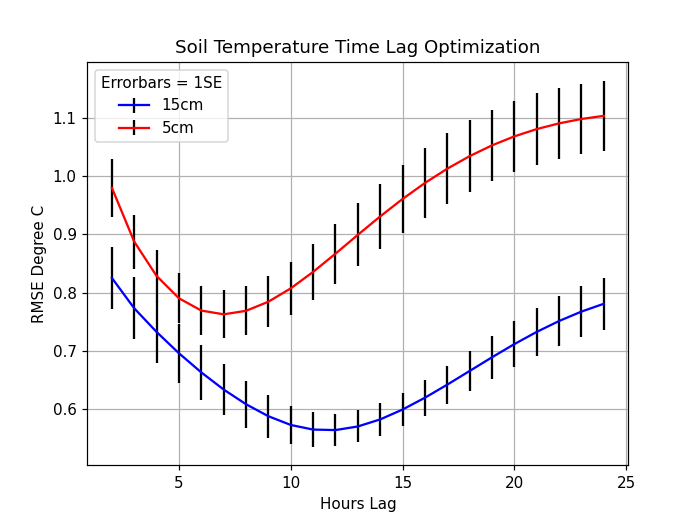

[12]
[7]


In [50]:
# from sklearn.model_selection import cross_val_score, cross_val_predict ,cross_validate, 

def Model_Test(X,y,AllData,K=10,Task = 'Predict'):
    Data = AllData[X+y].dropna()
#     print(Data)
    kf = KFold(n_splits=K)#,shuffle=True, random_state = 1)
    R2 = []
    RMSE = []
#     Pred = []
    Int = []
    Coef = []
    
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y])#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y])#.reshape(-1, 1)
        Mod = LinearRegression()
        Mod.fit(X_train, y_train)
#         R2.append(Mod.score(X_test, y_test))
        Test = Mod.predict(X_test)
        if y == ['VPD']:
            Test[Test<0]=0
        
        R2.append(metrics.r2_score(y_test,Test))
        RMSE.append(metrics.mean_squared_error(y_test,Test))
#         Pred.append(Mod.predict(AllData[X].interpolate()))
        Int.append(Mod.intercept_)
        Coef.append(Mod.coef_)
    Coef = np.mean(np.array(Coef),axis=0).mean(axis=0)
    Int = np.mean(np.array(Int))
    if Task == 'Predict':
        print()
        print(y[0])
        print('rmse', np.mean(np.array(RMSE)**.5))
        print('std rmse', np.std(np.array(RMSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('coef', Coef)
        print('int',Int)
        Pred = (AllData[X]*Coef).sum(axis=1) + Int
        return(Pred.values)
    elif Task == 'Optimize':
        return(np.mean(np.array(RMSE)**.5),np.std(np.array(RMSE)**.5))
    

X = ['tsoil_40','tsoil_10','tsoil_0','AirTemp_Rolling','Air Temp']#

K = 10
plt.figure()
U = []
S = []
I = []
M = 25
for i in range(2,M,1):
    I.append(i)
    Data['AirTemp_Rolling']=Data['Air Temp'].rolling(i).mean()
    y = ['Temp_15_1']
    Y = 'Deep'
    Val = Model_Test(X,y,Data.copy(),K=K,Task='Optimize')#.copy()
    U.append(Val[0])
    S.append(Val[1])
U = np.array(U)
S = np.array(S)
I = np.array(I)
US = U+S/K**.5
plt.errorbar(I,U,yerr=S/K**.5,color='b',ecolor='k',label='15cm')

print(I[U==U.min()])

U = []
S = []
# I = []
for i in range(2,M,1):
    Data['AirTemp_Rolling']=Data['Air Temp'].rolling(i).mean()
    y = ['Temp_5_1']
    Y = 'Shallow'
    Val = Model_Test(X,y,Data.copy(),K=K,Task='Optimize')#.copy()
    U.append(Val[0])
    S.append(Val[1])
U = np.array(U)
S = np.array(S)
US = U+S/K**.5
plt.errorbar(I,U,yerr=S/K**.5,color='r',ecolor='k',label='5cm')
plt.legend(title='Errorbars = 1SE')
plt.title('Soil Temperature Time Lag Optimization')
plt.ylabel('RMSE Degree C')
plt.xlabel('Hours Lag')
plt.grid()
plt.savefig('LagOptimized.png')
print(I[U==U.min()])

In [52]:

Data['AirTemp_Rolling']=Data['Air Temp'].rolling(12).mean()
y = ['Temp_15_1']
Y = 'Deep'
Val = Model_Test(X,y,Data.copy(),K=K)#,Task='Optimize')
Data[Y]=Val

Data['AirTemp_Rolling']=Data['Air Temp'].rolling(7).mean()
y = ['Temp_5_1']
Y = 'Shallow'
Val = Model_Test(X,y,Data.copy(),K=K)#,Task='Optimize')
Data[Y]=Val


Temp_15_1
rmse 0.5645828590152671
std rmse 0.0888434305678242
r2 0.7216356546817057
coef [ 1.02373429  0.15301172 -0.02399312  0.37369156 -0.30007637]
int 0.14773919530703444

Temp_5_1
rmse 0.7629993052632799
std rmse 0.12962697039105903
r2 0.7900143529492483
coef [ 1.125597    0.23301258  0.127715    0.60553467 -0.37200201]
int -0.5909718917031339


<IPython.core.display.Javascript object>


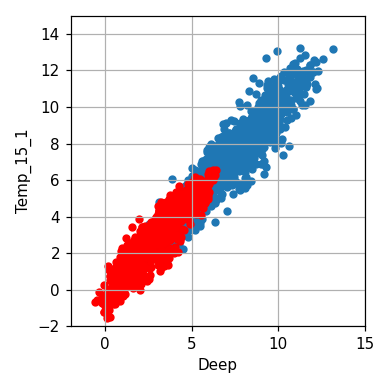

0.8976505336574037 6.155492798353904
0.8335489131313132


In [53]:

cm_2_in=1/2.54 
fig,ax=plt.subplots(figsize=(9.1*cm_2_in, 9.1*cm_2_in))

# Data.resample('D').mean().plot(kind='scatter',x='Shallow',y='Temp_5_1',ax=ax)
# Data.resample('D').mean().plot(kind='scatter',x='Shallow2',y='Temp_5_2',ax=ax,color='r')

Temp = Data.loc[((Data.index.year==2017)&
                (Data.index.dayofyear>174)&(Data.index.dayofyear<256))]#.resample('D')

# print(Temp)
Temp.plot(kind='scatter',x='Shallow',y='Temp_5_1',ax=ax)
Temp.plot(kind='scatter',x='Deep',y='Temp_15_1',ax=ax,color='r')

# print(metrics.r2_score(Temp['Shallow2'],Temp['Temp_5_2']),Temp['Temp_5_2'].mean())
print(metrics.r2_score(Temp['Shallow'],Temp['Temp_5_1']),Temp['Temp_5_1'].mean())


# print(metrics.r2_score(Temp['Deep2'],Temp['Temp_15_2']))
print(metrics.r2_score(Temp['Deep'],Temp['Temp_15_1']))


ax.grid()
ax.set_xlim(-2,15)
ax.set_ylim(-2,15)
plt.tight_layout()


VPD

VPD_est
rmse 134.06448727792366
std rmse 26.276785928606692
r2 0.7114612475562418
coef [0.75111742]
int 80.11208309954098


<IPython.core.display.Javascript object>


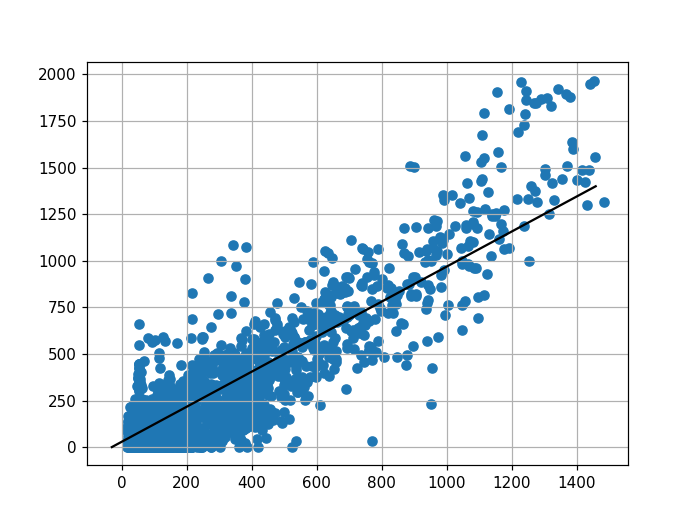

In [54]:

def getES(temp):
    es = 6.11 * np.exp((2.5e6 / 461) * (1 / 273 - 1 / (273 + temp)))
    return(es)
# }
def getVPD(rh,temp):
    es = getES(temp)
      ## calculate vapor pressure deficit
    vpd = ((100 - rh) / 100) * es
    return(vpd*100)
Temp = Data[['rhum','Air Temp','VPD']].dropna()
VPD2 = getVPD(Temp['rhum'],Temp['Air Temp'])

Data['VPD_est'] = getVPD(Data['rhum'],Data['Air Temp'])
print()
print('VPD')


y = ['VPD_est']#,'AirTemp_Avg']
X = ['VPD']
Y = 'Deep2'
Val = Model_Test(X,y,Data.copy())#,Pred=False)#.copy()
plt.figure()
plt.scatter(VPD2,Temp['VPD'])
plt.plot([-29.876398207013786,1400*1.06326534-29.876398207013786],[0,1400],color='k')
plt.grid()

In [55]:

print('Skeeter - AWS')
X = 'VPD_est'
y = 'VPD'

print(Data[[X,
             y]].corr())

DNA = Data[[X,
             y]].dropna()

Reg = LinearRegression().fit(DNA[[X]],DNA[y])
print(Reg.score(DNA[[X]],DNA[y]))
print(Reg.intercept_)

print(Reg.coef_)
print(metrics.mean_squared_error(DNA[X],DNA[y])**.5)


Skeeter - AWS
          VPD_est       VPD
VPD_est  1.000000  0.897962
VPD      0.897962  1.000000
0.8063357584914701
-30.035081547751986
[1.07275408]
160.7486337908561


In [135]:

# Data['MaxAngle'] = Data.groupby(Data.index.day)['Angle'].transform('max')
cols =['fch4','fco2','ch4_flux','co2_flux','ER',
       'Air Temp','Rainfall','Wind Speed','Wind direction',
        'Net SW Radiation','Net LW Radiation ','Net Radiation'
       'DOY','Daytime','DSSM','NDVI','Angle',
       'tsoil_0','tsoil_10','soilw_0','soilw_10',
       'Deep','Shallow','Deep2','Shallow2','VPD_est']
# Data[cols].to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland_2008/AWS_FI.csv')
# Data[cols].to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland_2012/AWS_FI.csv')
Data[cols].to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AWS_FI.csv')


datetime
2008-08-27 19:00:00    NaN
2008-08-27 20:00:00    NaN
2008-08-27 21:00:00    NaN
2008-08-27 22:00:00    NaN
2008-08-27 23:00:00    NaN
                      ... 
2019-07-22 20:00:00    NaN
2019-07-22 21:00:00    NaN
2019-07-22 22:00:00    NaN
2019-07-22 23:00:00    NaN
2019-07-23 00:00:00    1.0
Name: SnowFree, Length: 95550, dtype: float64


<IPython.core.display.Javascript object>


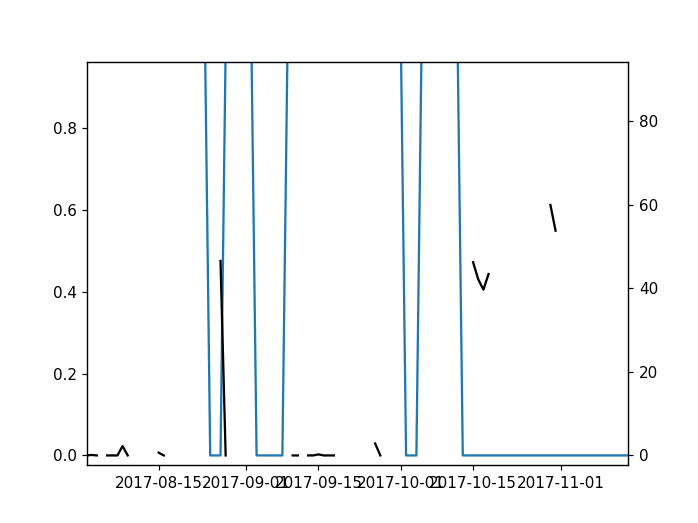

In [164]:
# print(Data.groupby(Data.index.dayofyear).mean())
# print()
print(Data['SnowFree'])
plt.figure()
plt.plot(Data['SnowFree'].resample('D').max())
x2 = plt.twinx()
x2.plot(Data['NDSI_Snow_Cover_FishIsland'].resample('D').max(),color='k')
# print(Data.resample('Y').sum()['SnowFree']-Data.resample('Y').max()['DSSM'])
# print(Data.loc[Data['DSSM']>0].resample('Y').sum()['Snow']/24-Data.loc[Data['DSSM']>0].resample('Y').count()['Snow']/24)
# print(Data.resample('Y').max()['DSSM']-Data.resample('Y').sum()['Snow']/24)

In [4]:

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib notebook

    Min of_NDVI  Max of_NDVI      Label  Count
0          0.03         0.04  0.03-0.04      6
1          0.04         0.05  0.04-0.05      1
2          0.05         0.06  0.05-0.06      4
3          0.06         0.07  0.06-0.07      4
4          0.07         0.08  0.07-0.08      0
5          0.08         0.09  0.08-0.09      0
6          0.09         0.11  0.09-0.11      0
7          0.11         0.12  0.11-0.12      0
8          0.12         0.13  0.12-0.13      0
9          0.13         0.14  0.13-0.14      0
10         0.14         0.15  0.14-0.15      0
11         0.15         0.16  0.15-0.16      0
12         0.16         0.17  0.16-0.17      0
13         0.17         0.18  0.17-0.18      0
14         0.18         0.19  0.18-0.19      4
15         0.19         0.20   0.19-0.2      0
16         0.20         0.21   0.2-0.21      0
17         0.21         0.22  0.21-0.22      0
18         0.22         0.23  0.22-0.23      0
19         0.23         0.24  0.23-0.24      0
20         0.

<IPython.core.display.Javascript object>


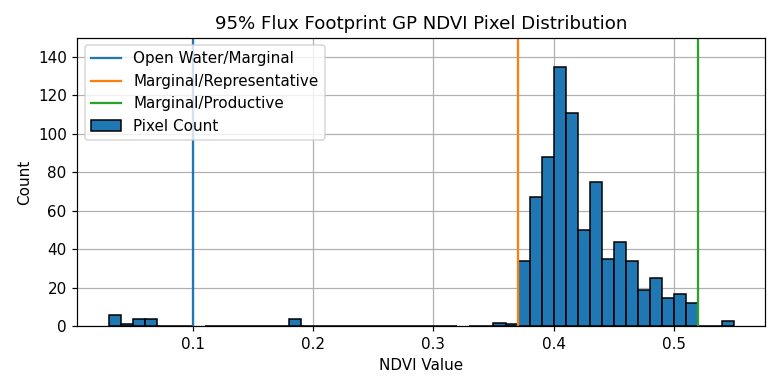

In [15]:

LC = pd.read_csv('Landscape_Class.csv')
print(LC)
cm_2_in=1/2.54 
fig,ax=plt.subplots(figsize=(18.2*cm_2_in, 9.1*cm_2_in))

# LC.plot(kind='bar',x='Min of_NDVI',y='Count',ax=ax,legend=None,edgecolor='k')
ax.bar(LC['Min of_NDVI']+.005,LC['Count'],width=.01,edgecolor='k',label='Pixel Count')
# print(LC['Min of_NDVI'])
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
# for label in ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)
ax.plot([.1,.1],[0,150],label='Open Water/Marginal')
ax.plot([.37,.37],[0,150],label='Marginal/Representative')
ax.plot([.52,.52],[0,150],label='Marginal/Productive')
ax.set_ylim(0,150)
ax.set_axisbelow(True)
ax.grid()
ax.set_ylabel('Count')
ax.legend()
ax.set_xlabel('NDVI Value')
ax.set_title('95% Flux Footprint GP NDVI Pixel Distribution')
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Google Drive\\PhD_Thesis\\Chapter3_Figs/FP_Dist.jpg',dpi=600)

,## NARR/AWS/EC Relationships

In [189]:
Temp = Data.loc[((Data.index.year>2008)&(Data.index.year<2019)&
                (Data.index.dayofyear>174)&(Data.index.dayofyear<256))]
Temp2 = Temp.loc[Temp.index.year==2017]
print(Comp.dfNARR.columns)
print(Comp.dfTaglu.columns)

Index(['tsoil_0', 'soilw_0', 'soill_0', 'tsoil_10', 'soilw_10', 'soill_10',
       'tsoil_40', 'soilw_40', 'soill_40', 'tsoil_100', 'soilw_100',
       'soill_100', 'air', 'vwnd', 'dswrf', 'apcp', 'uwnd', 'pres', 'rhum',
       'dlwrf', 'ulwrf', 'uswrf', 'Wind_Speed', 'Wind_Dir'],
      dtype='object')
Index(['RECORD', 'AirTemp', 'AirTemp_Avg', 'Rainfall_Tot', 'SoilMoist(1)',
       'SoilMoist(2)', 'SoilMoist(3)', 'SoilMoist(4)', 'SoilMoist(5)',
       'SoilMoist(6)', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg', 'Net_Ttl_Rad_Avg',
       'WindSpd', 'WindDir', 'Unnamed: 16', 'Unnamed: 17',
       'Delta_SoilMoist(4)', 'Delta_SoilMoist(5)', 'Total_Rainfall_Tot'],
      dtype='object')


### 1) Soil Temps

<IPython.core.display.Javascript object>


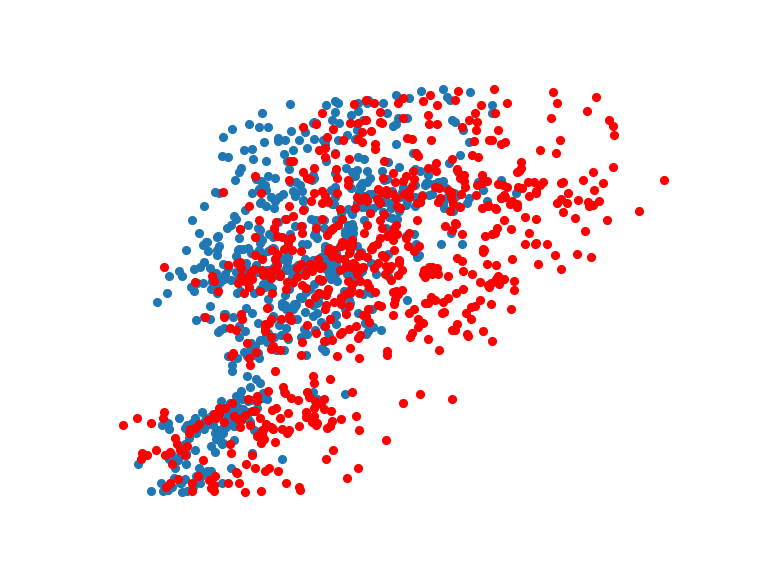

5 v 10
Cent
0.41329787842735244
2.714090639447409
3.468429217519002
Rim
0.369731925366778
2.953530722668228
13.436171501828689

2.5 v. 0
Cent
0.4578814913484932
0.3658139841848165
36.45851987238397
Rim
0.5851342280678739
-0.7376065126106717
19.47121254681519


<IPython.core.display.Javascript object>


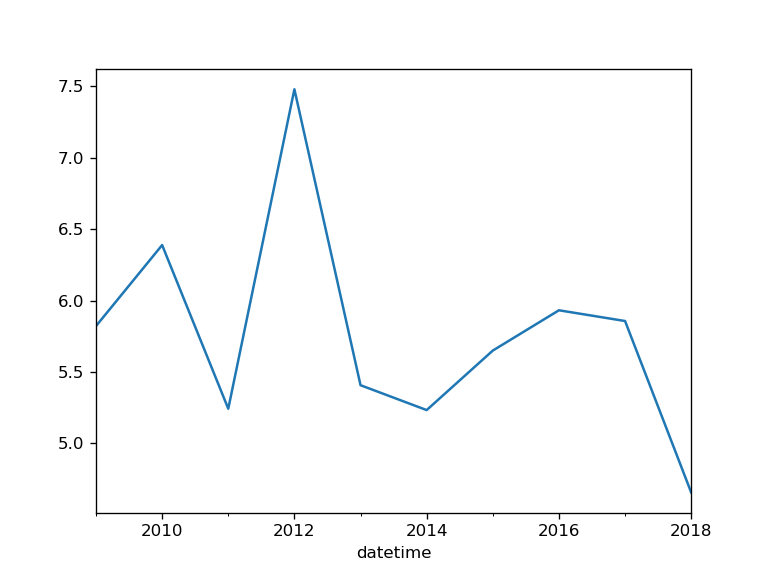

In [190]:
from sklearn.linear_model import LinearRegression
Temp2 = Temp.loc[Temp.index.year==2017].resample('3H').mean()
# print(Temp2[['Temp_2_5_1','Temp_5_1','Temp_15_1',
#              'Temp_2_5_2','Temp_5_2','Temp_15_2',
#              'tsoil_0','tsoil_10']].corr())
fig,ax=plt.subplots()
Temp2.plot(kind='scatter',x='Temp_5_1',y='tsoil_10',ax=ax)
Temp2.plot(kind='scatter',x='Temp_5_2',y='tsoil_10',ax=ax,color='r')
# Temp2.plot(kind='scatter',x='Temp_15_1',y='tsoil_10',ax=ax,color='r')
print('5 v 10')
print('Cent')
Reg = LinearRegression().fit(Temp2[['Temp_5_1']],Temp2['tsoil_10'])
print(Reg.score(Temp2[['Temp_5_1']],Temp2['tsoil_10']))
print(Reg.intercept_)
print(metrics.mean_squared_error(Temp2['Temp_5_1'],Temp2['tsoil_10']))
print('Rim')
Reg = LinearRegression().fit(Temp2[['Temp_5_2']],Temp2['tsoil_10'])
print(Reg.score(Temp2[['Temp_5_2']],Temp2['tsoil_10']))
print(Reg.intercept_)
print(metrics.mean_squared_error(Temp2['Temp_5_2'],Temp2['tsoil_10']))

print()

print('2.5 v. 0')
print('Cent')
Reg = LinearRegression().fit(Temp2[['Temp_2_5_1']],Temp2['tsoil_0'])
print(Reg.score(Temp2[['Temp_2_5_1']],Temp2['tsoil_0']))
print(Reg.intercept_)
print(metrics.mean_squared_error(Temp2['Temp_2_5_1'],Temp2['tsoil_0']))

print('Rim')
Reg = LinearRegression().fit(Temp2[['Temp_2_5_2']],Temp2['tsoil_0'])
print(Reg.score(Temp2[['Temp_2_5_2']],Temp2['tsoil_0']))
print(Reg.intercept_)
print(metrics.mean_squared_error(Temp2['Temp_2_5_2'],Temp2['tsoil_0']))

plt.figure()
Temp['tsoil_10'].resample('Y').mean().plot()

### 2) Soil Moisture

### 3) Rainfall


0.9845331473974647
-0.007341761546904191
[0.90733322]


<IPython.core.display.Javascript object>


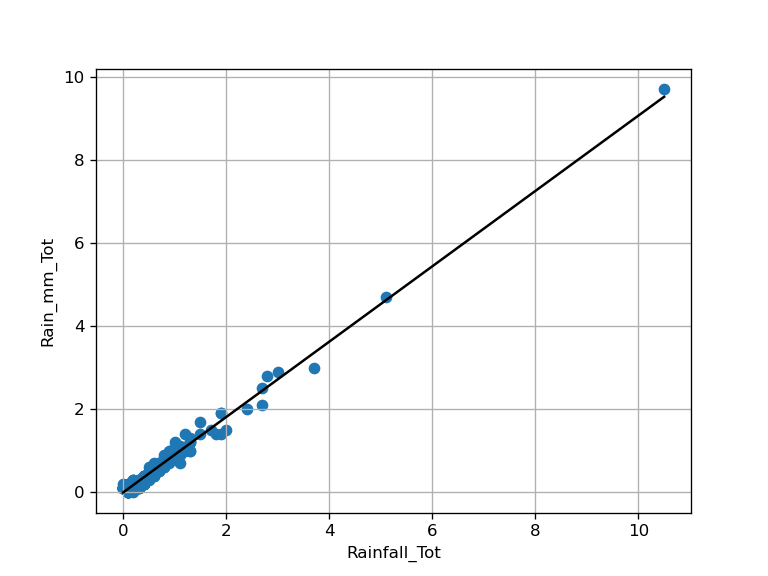

            Rainfall_Tot  Rain_mm_Tot        apcp
datetime                                         
2009-12-31           5.1          0.0   44.760249
2010-12-31          87.2          0.0   91.147077
2011-12-31          28.3          0.0   28.104234
2012-12-31          89.6          0.0   56.333488
2013-12-31         107.4          0.0   96.719577
2014-12-31          70.5          0.0   79.854833
2015-12-31         127.6          0.0  116.679773
2016-12-31          57.2          0.0   59.642829
2017-12-31         111.5         99.6  125.822948
2018-12-31         105.5          0.0   98.401901


In [197]:

# Temp = Data.loc[((Data.index.year>2008)&(Data.index.year<2019)&
#                 (Data.index.dayofyear>174)&(Data.index.dayofyear<256))]
# DNA = Temp[['apcp',X]].dropna().resample('D').sum()
# Reg = LinearRegression().fit(DNA[['apcp']],DNA[X])
# print(Reg.score(DNA[['apcp']],DNA[X]))
# print(Reg.intercept_)

# Reg = LinearRegression().fit(DNA[['apcp']],DNA[X])
# print(Reg.score(DNA[['apcp']],DNA[X]))
# print(Reg.intercept_)


X = 'Rainfall_Tot'
y = 'Rain_mm_Tot'
DNA = Temp2[[X,y]].resample('D').sum()
Temp5 = Data.loc[Data[[X,y]].sum(axis=1)>0]
DNA = Temp5[[X,y]].dropna()
Reg = LinearRegression().fit(DNA[[X]],DNA[y])
# print(Reg)

print()
print(Reg.score(DNA[[X]],DNA[y]))
print(Reg.intercept_)
print(Reg.coef_)
plt.figure()
plt.scatter(DNA[X],DNA[y])
plt.plot(DNA[X].sort_values(),Reg.coef_*DNA[X].sort_values()+ Reg.intercept_,color='k')
plt.grid()
plt.xlabel(X)
plt.ylabel(y)


# print(Temp2[[y,'apcp',X]].resample('D').sum().corr())
# print(Temp2[[y,'apcp',X]].sum())

# Reg = LinearRegression().fit(DNA[[y]],DNA[X])#.resample('D').sum()
# print(Reg.score(DNA[[y]],DNA[X]))
# print(Reg.intercept_)

print(Temp[[X,y,'apcp']].resample('Y').sum())
# plt.figure()
# plt.errorbar(Temp['SoilMoist(4)'].resample('Y').mean().index,Temp['SoilMoist(4)'].resample('Y').mean(),
#         yerr=Temp['SoilMoist(4)'].resample('Y').std())
# plt.scatter(Temp[X].resample('Y').sum(),Temp['soilw_10'].resample('Y').mean())

### 4) Temperature

In [273]:

print('Skeeter - AWS')
X = 'AirTemp_Avg'
y = 'AirTC_Avg'

print(Temp2[[X,
             y]].corr())

DNA = Temp2[[X,
             y]].dropna()

Reg = LinearRegression().fit(DNA[[X]],DNA[y])
print(Reg.score(DNA[[X]],DNA[y]))
print(Reg.intercept_)

print(Reg.coef_)
print(metrics.mean_squared_error(DNA[X],DNA[y])**.5)

Skeeter - AWS
             AirTemp_Avg  AirTC_Avg       air
AirTemp_Avg     1.000000   0.999349  0.865630
AirTC_Avg       0.999349   1.000000  0.866481
air             0.865630   0.866481  1.000000
0.998699163985429
-0.05253152565375174
[0.99709067]
0.19279121980121838


### 5) Wind Speed

In [274]:

print('Skeeter - AWS')
X = 'WindSpd'
y = 'wind_speed'

print(Temp2[[X,
             y]].corr())

DNA = Temp2[[X,
             y]].dropna()

Reg = LinearRegression().fit(DNA[[X]],DNA[y])
print(Reg.score(DNA[[X]],DNA[y]))
print(Reg.intercept_)

print(Reg.coef_)
print(metrics.mean_squared_error(DNA[X],DNA[y])**.5)

Skeeter - AWS
             WindSpd  wind_speed
WindSpd     1.000000    0.975164
wind_speed  0.975164    1.000000
0.9509445607080741
0.21373086289805254
[0.9463161]
0.3994781954149411


### 6) Radiation

Skeeter - AWS
0.9773176110873464
-14.923238042977118
[1.24242253]
43.03465611772779


<IPython.core.display.Javascript object>


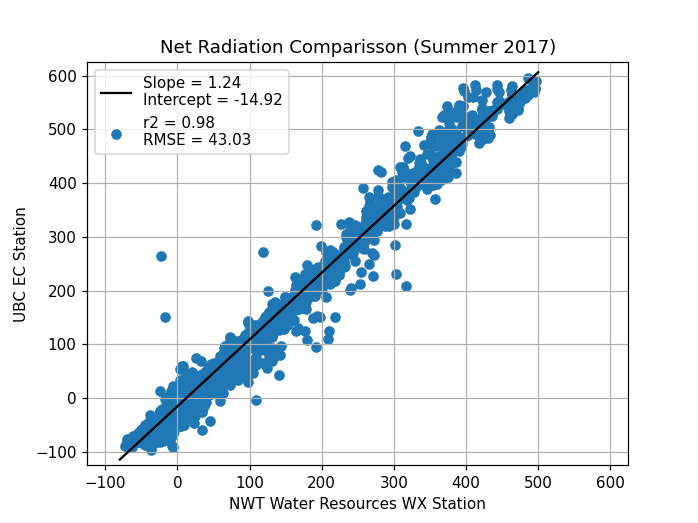

In [85]:

print('Skeeter - AWS')
X = 'Net_Ttl_Rad_Avg'
y = 'NR_Wm2_Avg'

# print(Temp2[[X,
#              y]].corr())

DNA = Data[[X,
             y]].dropna()

Reg = LinearRegression().fit(DNA[[X]],DNA[y])
print(Reg.score(DNA[[X]],DNA[y]))
print(Reg.intercept_)

print(Reg.coef_)
print(metrics.mean_squared_error(DNA[X],DNA[y])**.5)


plt.figure()
plt.scatter(DNA[X],DNA[y],label='r2 = '+str(np.round(Reg.score(DNA[[X]],DNA[y]),
         2))+'\nRMSE = '+str(np.round(metrics.mean_squared_error(DNA[X],
         DNA[y])**.5,2)))
plt.plot([-80,500],[Reg.coef_*-80+Reg.intercept_,Reg.coef_*500+Reg.intercept_],color='k',
        label='Slope = '+str(np.round(Reg.coef_[0],2))+'\nIntercept = '+str(np.round(Reg.intercept_,2)))
plt.xlabel('NWT Water Resources WX Station')
plt.ylabel('UBC EC Station')
plt.grid()
plt.ylim(-125,625)
plt.xlim(-125,625)
plt.legend()
plt.title('Net Radiation Comparisson (Summer 2017)')
plt.savefig('RadiationComp.png')

Skeeter - AWS
0.9902588645605975
3.849540833554613
[2.3802965]
301.1033206364618


<IPython.core.display.Javascript object>


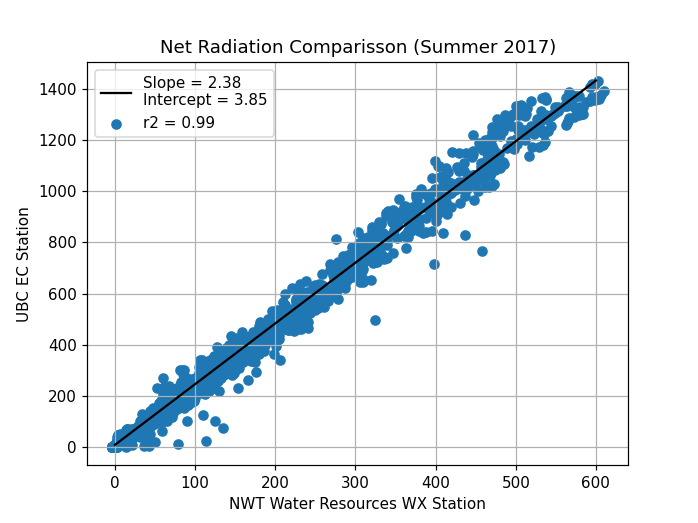

In [84]:

print('Skeeter - AWS')
X = 'Net_SW_Wm2_Avg'
y = 'PPFD_Avg'

# print(Temp2[[X,
#              y]].corr())

DNA = Data[[X,
             y]].dropna()

Reg = LinearRegression().fit(DNA[[X]],DNA[y])
print(Reg.score(DNA[[X]],DNA[y]))
print(Reg.intercept_)

print(Reg.coef_)
print(metrics.mean_squared_error(DNA[X],DNA[y])**.5)


plt.figure()
plt.scatter(DNA[X],DNA[y],label='r2 = '+str(np.round(Reg.score(DNA[[X]],DNA[y]),
         2)))
#             +'\nRMSE = '+str(np.round(metrics.mean_squared_error(DNA[X],
#          DNA[y])**.5,2)))
plt.plot([0,600],[Reg.coef_*+Reg.intercept_,Reg.coef_*600+Reg.intercept_],color='k',
        label='Slope = '+str(np.round(Reg.coef_[0],2))+'\nIntercept = '+str(np.round(Reg.intercept_,2)))
plt.xlabel('NWT Water Resources WX Station')
plt.ylabel('UBC EC Station')
plt.grid()
# plt.ylim(-125,625)
# plt.xlim(-125,625)
plt.legend()
plt.title('Net Radiation Comparisson (Summer 2017)')
plt.savefig('PPFDComp.png')

Cent. 10cm    0.746131
Cent. 20cm    0.899278
Cent. 40cm    0.997885
Rim 10cm      0.985740
Rim 20cm      1.000000
Rim 40cm      0.633588
dtype: float64


<IPython.core.display.Javascript object>


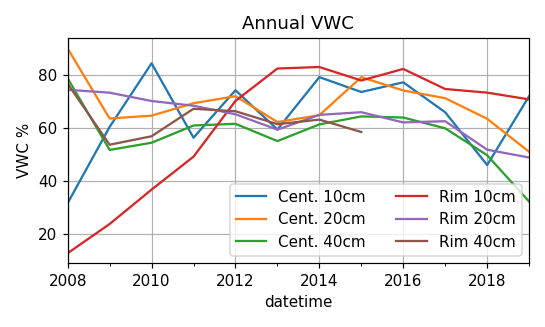

<IPython.core.display.Javascript object>


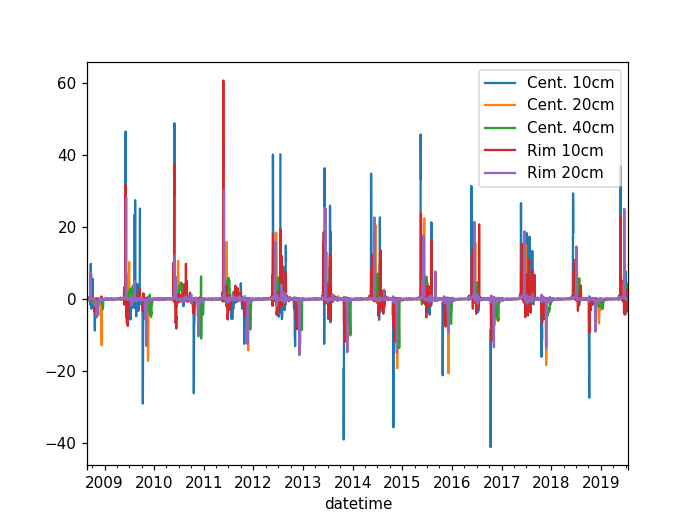

In [51]:
T30 = Comp.dfTaglu.copy()

T30 = T30.rename(columns={'SoilMoist(1)':'Cent. 10cm',
                          'SoilMoist(2)':'Cent. 20cm',
                          'SoilMoist(3)':'Cent. 40cm',
                          'SoilMoist(4)':'Rim 10cm',
                          'SoilMoist(5)':'Rim 20cm',
                          'SoilMoist(6)':'Rim 40cm'}
                 )
print(T30[['Cent. 10cm',
'Cent. 20cm',
'Cent. 40cm',
'Rim 10cm',
'Rim 20cm',
'Rim 40cm'
                 ]].count()/T30.count()['RECORD'])
fig,ax = plt.subplots(figsize=(5,3))
T30.loc[((T30.index.month>5)&(T30.index.month<10)),['Cent. 10cm',
'Cent. 20cm',
'Cent. 40cm',
'Rim 10cm',
'Rim 20cm',
'Rim 40cm'
                                                         ]].resample('Y').mean().plot(ax=ax)
ax.set_title('Annual VWC')
ax.set_ylabel('VWC %')
ax.grid()
ax.legend(ncol=2)
plt.tight_layout()
plt.savefig('AnualVWC.png')

# T30['DOY']=T30.index.dayofyear
Max = T30[['Cent. 10cm',
'Cent. 20cm',
'Cent. 40cm',
'Rim 10cm',
'Rim 20cm',
# 'Rim 40cm'
 ]].resample('D').max()

Max.diff().plot()




<IPython.core.display.Javascript object>


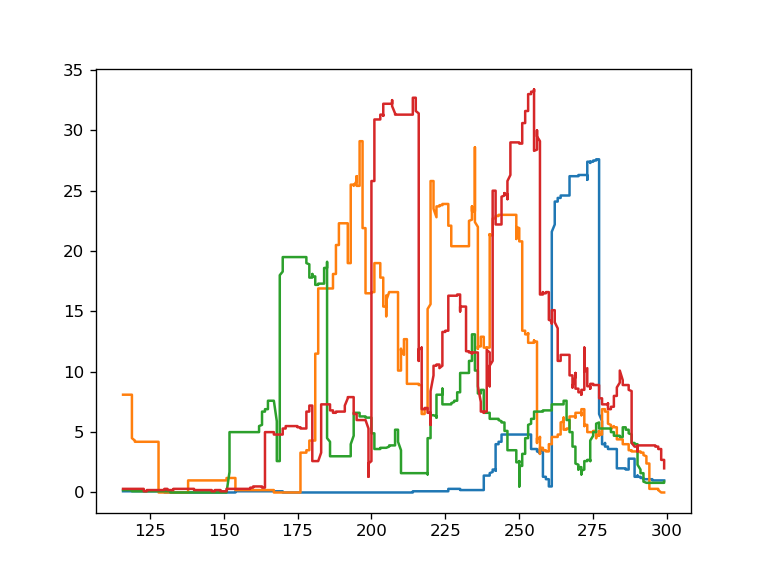

In [233]:
plt.figure()
Start = 100
End = 300
Days = 16
for y in range(2008,2013):
    if y > 2008 and y<2019:
        i = y-2009
        Year = Data.loc[((Data.index.year==y)&
                        (Data.index.dayofyear>Start)&(Data.index.dayofyear<End)),'Rainfall_Tot'].rolling(24*Days).sum()
#         print(Year)
        plt.plot(Year.index.dayofyear,Year)

Daytime
0     164
1    1277
Name: fch4, dtype: int64
Daytime
0     302
1    2199
Name: fco2, dtype: int64


<IPython.core.display.Javascript object>


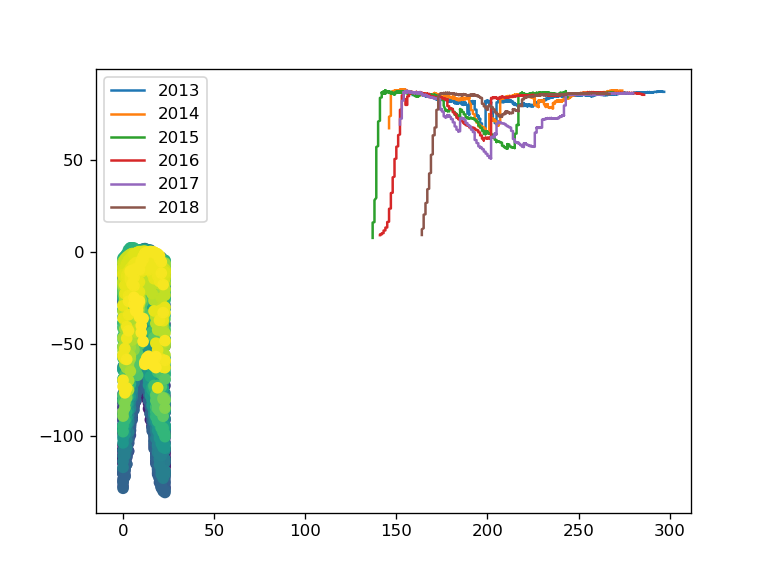

Index(['RECORD', 'AirTemp', 'AirTemp_Avg', 'Rainfall_Tot', 'SoilMoist(1)',
       'SoilMoist(2)', 'SoilMoist(3)', 'SoilMoist(4)', 'SoilMoist(5)',
       'SoilMoist(6)', 'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg', 'Net_Ttl_Rad_Avg',
       'WindSpd', 'WindDir', 'Unnamed: 16', 'Unnamed: 17',
       'Delta_SoilMoist(4)', 'Delta_SoilMoist(5)', 'Total_Rainfall_Tot'],
      dtype='object')

In [6]:
# from datetime import datetime as dt
# LAT = 69.36666
# LON = -134.86
# TZ = -7
# Data = Data.loc[((Data.index.year==2017)&(Data.index.month>=9)&(Data.index.month<=9))]
# JD = 2457927.5
# i = 0
# Data['Angle'] = np.nan
# Data['Azimuth'] = np.nan
# Data['Zenith'] = np.nan
# # Data['Dark']=0
# for index,JD,HOUR in zip(Data.index.values,pd.DatetimeIndex(Data.index.date).to_julian_date().values,Data.index.hour.values):
#     TIME=HOUR/24
#     print(TIME)
#     Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset = SunStas(LAT,LON,JD,TIME,TZ)
#     Data.loc[Data.index==index,'Angle'] = Angle_Corr
#     Data.loc[Data.index==index,'Sunrise'] = Sunrise
#     Data.loc[Data.index==index,'Sunset'] = Sunset
# print(Data['Sunset'],Data['Sunrise'])
print(Data.loc[np.isnan(Data['fch4'])==False].groupby('Daytime').count()['fch4'])
print(Data.loc[np.isnan(Data['fco2'])==False].groupby('Daytime').count()['fco2'])

Temp = Data.loc[Data['Snow']>=1]
# Data['Snow']
plt.figure()
for i in range(2013,2019):
    Sel = Temp.loc[Temp.index.year==i]
    plt.plot(Sel.index.dayofyear,Sel['SoilMoist(4)'],label=str(i))#.groupby(Comp.dfTaglu.index.year).count()/Comp.dfTaglu[['AirTemp']].groupby(Comp.dfTaglu.index.year).count().values
plt.legend()
Comp.dfTaglu.columns

In [7]:
# plt.figure()
# plt.plot(Data.groupby(Data.DOY).mean().)
Temp = Data.loc[((Data.index.year==2017)&(Data.index.month>=6)&(Data.index.month<=9))]
plt.scatter(Temp.index.hour,Temp.Net_LW_Wm2_Avg,c=Temp.DOY)
# YM = Data.groupby(Data.index.year).max()['DSSM']4
Data['Year']=Data.index.year
Data['Hour']=Data.index.year
print(Data.groupby('Year')['Net_LW_Wm2_Avg'])
# print(YM)
# plt.figure()
# plt.plot(Data.loc[Data.DSSM==1].index.year,Data.loc[Data.DSSM==1].index.dayofyear)
# plt.plot(Data.loc[Data.DSSM==1].index.year,Data.loc[Data.DSSM==1].index.dayofyear+)

ch4_flux          1441
ch4_noSSFilter    2041
dtype: int64


<IPython.core.display.Javascript object>


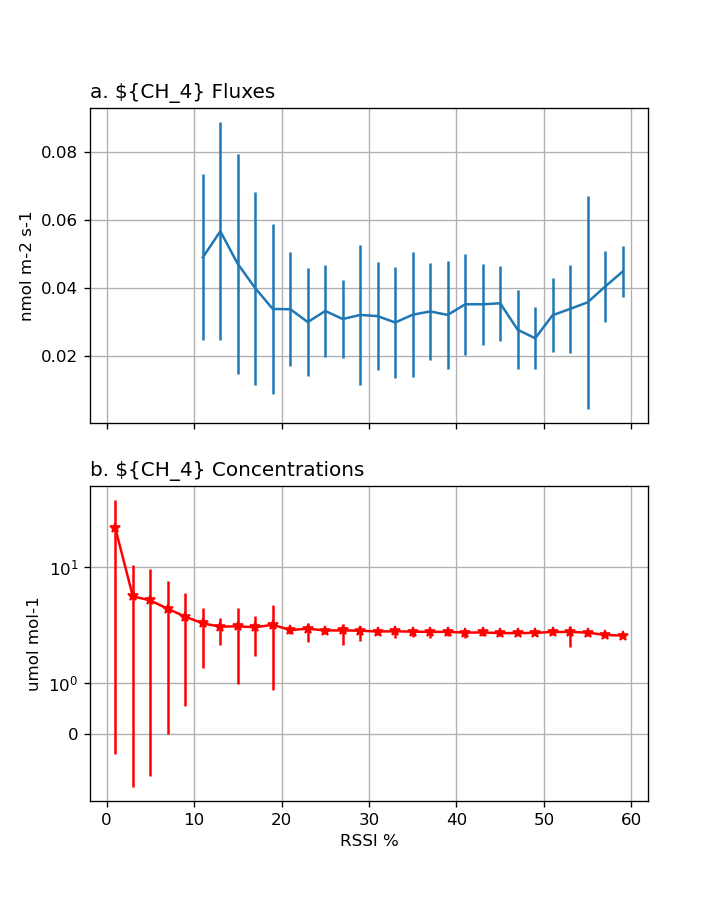

In [9]:

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

Data = Comp.Data.copy()
print(Data[['ch4_flux','ch4_noSSFilter']].count())

Data['RSSI'] = pd.cut(Data['rssi_77_mean'],np.arange(0,65,2),labels=np.arange(0,63,2)+1)
Temp = Data.loc[Data['rssi_77_mean']>0,['ch4_mean','ch4_flux','ch4_noSSFilter','RSSI','NR_Wm2_Avg']].groupby('RSSI').mean()
# Tempd = Data[['ch4_mean','ch4_flux','RSSI','NR_Wm2_Avg']].groupby('RSSI').count()
Temps = Data[['ch4_mean','ch4_flux','ch4_noSSFilter','RSSI','NR_Wm2_Avg']].groupby('RSSI').std()
# print(Temp)
fig,ax=plt.subplots(2,1,figsize=(6,7.5),sharex=True)
ax[0].errorbar(Temp.index,Temp['ch4_noSSFilter'],yerr=Temps['ch4_noSSFilter'])
ax[0].grid()
ax[0].set_ylabel('nmol m-2 s-1')
# ax[0].set_xlabel('RSSI %')
ax[0].set_title(r'a. ${CH_4} Fluxes',loc='left')
# x2 = plt.twinx()
ax[1].set_title('b. ${CH_4} Concentrations',loc='left')
ax[1].errorbar(Temp.index,Temp['ch4_mean'],marker='*',yerr=Temps['ch4_mean'],color='r')
ax[1].set_xlabel('RSSI %')
ax[1].set_yscale('symlog')
ax[1].grid()
ax[1].set_ylabel('umol mol-1')
plt.savefig('RSSI.jpg',dpi=600)

<IPython.core.display.Javascript object>


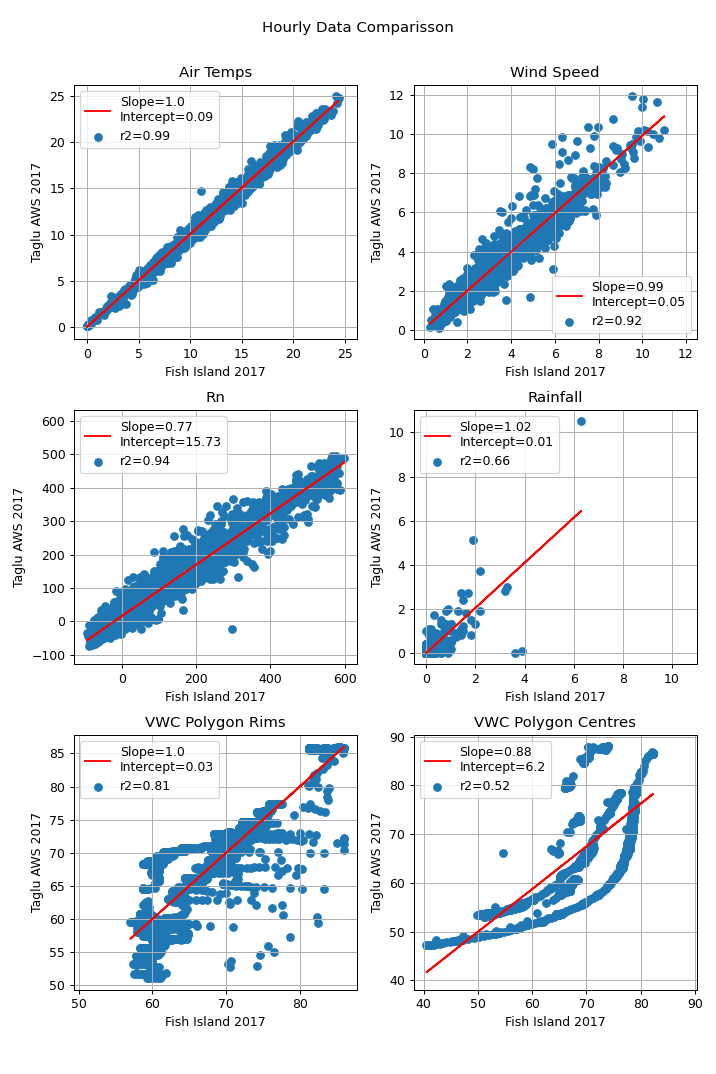

Text(0.5, 0.98, 'Hourly Data Comparisson')

In [554]:
def Plot(A,B,ax,ofs=.05,yl = 'Taglu AWS 2017'):
    Temp = GS[[A,B]].dropna()
    LR = stats.linregress(Temp[A],Temp[B])
    # print(LR)
    ax.scatter(Temp[A],Temp[B],label='r2='+str(np.round(LR[2]**2,2)))
    ax.plot(Temp[A],Temp[A]*LR[0]+LR[1],c='r',label='Slope='+str(np.round(LR[0],2))+'\n'+\
                                                                'Intercept='+str(np.round(LR[1],2)))
    ax.set_xlabel('Fish Island 2017')
    ax.set_ylabel(yl)
    mn = min(Temp[A].min(),Temp[B].min())
    mx = max(Temp[A].max(),Temp[B].max())
    
#     ax.set_yticks(ax.get_xticks())
    ax.grid()
    ax.set_ylim(mn-(mx-mn)*ofs,mx+(mx-mn)*ofs)
    ax.set_xlim(mn-(mx-mn)*ofs,mx+(mx-mn)*ofs)
    ax.legend()
    
fig,axes = plt.subplots(3,2,figsize=(8,12))

A = 'AirTC_Avg'
B = 'AirTemp_Avg'
ax = axes[0,0]
Plot(A,B,ax)
ax.set_title('Air Temps')

A = 'wind_speed'
B = 'WindSpd'
ax = axes[0,1]
Plot(A,B,ax)
ax.set_title('Wind Speed')

A = 'NR_Wm2_Avg'
B = 'Net_Ttl_Rad_Avg'
ax = axes[1,0]
Plot(A,B,ax)
ax.set_title('Rn')

A = 'Rain_mm_Tot'
B = 'Rainfall_Tot'
ax = axes[1,1]
Plot(A,B,ax)
ax.set_title('Rainfall')

A = 'VWC_2'
B = 'SoilMoist(4)'
ax = axes[2,0]
Plot(A,B,ax)
ax.set_title('VWC Polygon Rims')

A = 'VWC_1'
B = 'SoilMoist(1)'
ax = axes[2,1]
Plot(A,B,ax)
ax.set_title('VWC Polygon Centres')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Hourly Data Comparisson')

# Taglu AWS station data comparissons and patterns

<IPython.core.display.Javascript object>


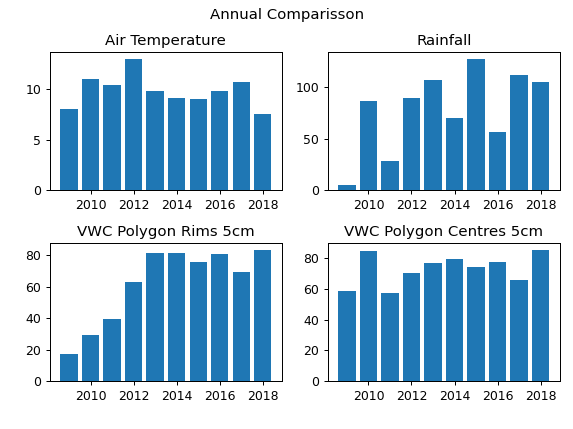

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Record Completeness')

In [576]:
GS = Comp.AllData.loc[((Comp.AllData.index.year>2008)&(Comp.AllData.index.year<2019)&\
                       (Comp.AllData.index.dayofyear>Comp.Data.DOY.min())&(Comp.AllData.index.dayofyear<Comp.Data.DOY.max()))]

Year = GS.groupby(GS.index.year).mean()
YearC = GS.groupby(GS.index.year).count()
YearS = GS.groupby(GS.index.year).sum()
fig,ax=plt.subplots(2,2)
ax[0,0].bar(Year.index,Year['AirTemp_Avg'])
ax[0,0].set_title('Air Temperature')
ax[0,1].bar(YearS.index,YearS['Rainfall_Tot'])
ax[0,1].set_title('Rainfall')
ax[1,1].bar(Year.index,Year['SoilMoist(1)'])
ax[1,1].set_title('VWC Polygon Centres 5cm')
ax[1,0].bar(Year.index,Year['SoilMoist(4)'])
ax[1,0].set_title('VWC Polygon Rims 5cm')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Annual Comparisson')

# plt.figure()
# plt.scatter(GS.index,GS['SoilMoist(1)'],label='Cent.')
# plt.scatter(GS.index,GS['SoilMoist(4)'],label='Rim')
# plt.legend()

fig,ax=plt.subplots(2)
ax[1].bar(Year.index,YearC['SoilMoist(1)']/YearC['AirTemp_Avg']*100)
ax[1].set_title('VWC Polygon Centres')
ax[0].bar(Year.index,YearC['SoilMoist(4)']/YearC['AirTemp_Avg']*100)
ax[0].set_title('VWC Polygon Rims')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Record Completeness')





# NARR Soil temps vs. Fish Island

<IPython.core.display.Javascript object>


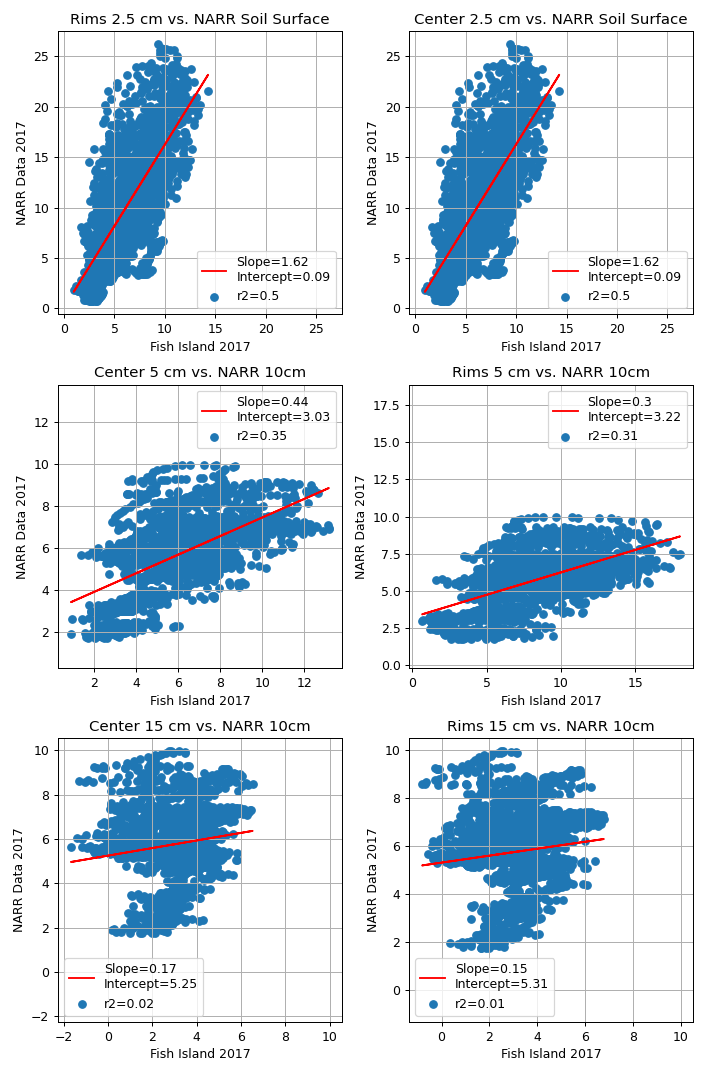

In [556]:
fig,axes=plt.subplots(3,2,figsize=(8,12))

A = 'Temp_2_5_1'
B = 'tsoil_0'
ax=axes[0,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 2.5 cm vs. NARR Soil Surface')

A = 'Temp_2_5_1'
B = 'tsoil_0'
ax=axes[0,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 2.5 cm vs. NARR Soil Surface')

A = 'Temp_5_1'
B = 'tsoil_10'
ax=axes[1,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 5 cm vs. NARR 10cm')

A = 'Temp_5_2'
B = 'tsoil_10'
ax=axes[1,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 5 cm vs. NARR 10cm')

A = 'Temp_15_1'
B = 'tsoil_10'
ax=axes[2,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 15 cm vs. NARR 10cm')

A = 'Temp_15_2'
B = 'tsoil_10'
ax=axes[2,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 15 cm vs. NARR 10cm')
plt.tight_layout()


# Taglu AWS vs. NARR: VWC

<IPython.core.display.Javascript object>


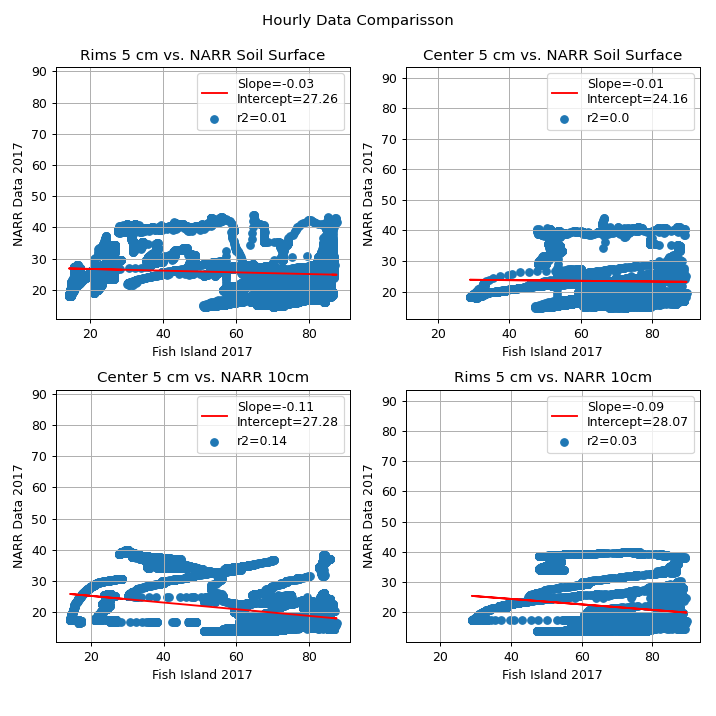

Text(0.5, 0.98, 'Hourly Data Comparisson')

In [577]:
fig,axes=plt.subplots(2,2,figsize=(8,8
                                  ))

A = 'SoilMoist(4)'
B = 'soill_0'
ax=axes[0,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 5 cm vs. NARR Soil Surface')

A = 'SoilMoist(1)'
B = 'soill_0'
ax=axes[0,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 5 cm vs. NARR Soil Surface')

A = 'SoilMoist(4)'
B = 'soill_10'
ax=axes[1,0]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Center 5 cm vs. NARR 10cm')

A = 'SoilMoist(1)'
B = 'soill_10'
ax=axes[1,1]
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('Rims 5 cm vs. NARR 10cm')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Hourly Data Comparisson')

Index(['soill_0', 'tsoil_0', 'soilw_0', 'soill_10', 'tsoil_10', 'soilw_10',
       'soill_40', 'tsoil_40', 'soilw_40', 'hpbl', 'ulwrf', 'apcp', 'uwnd',
       'dlwrf', 'dswrf', 'uswrf', 'air', 'tcdc', 'pres', 'vwnd', 'Wind_Speed',
       'Wind_Dir', 'MT'],
      dtype='object')


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<IPython.core.display.Javascript object>


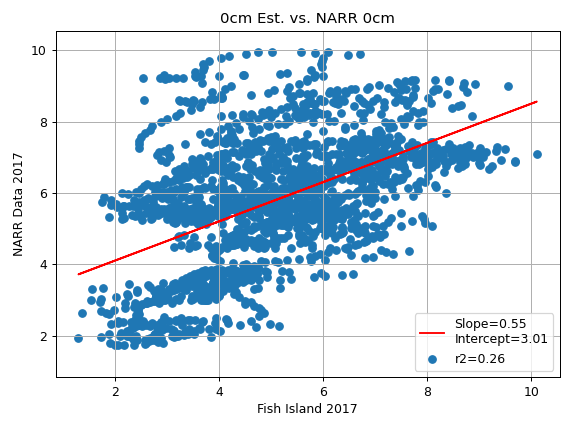

In [558]:
print(Comp.dfNARR.columns)



def Fit(X,Y,M=1):
    x=np.arange(0,41)
    if M == 2:
        z = np.polyfit(X, Y, 2)
        z0 = ((z[0]*x**2+z[1]*x+z[2])[0])
        z = np.polyfit(X, Y, 2)
        z10 = ((z[0]*x**2+z[1]*x+z[2])[10])
    else:
        z = np.polyfit(X, Y,1)
        z0 = ((z[0]*x+z[1])[0])
        z = np.polyfit(X, Y,1)
        z10 = ((z[0]*x+z[1])[10])
    return(z0,z10)
    
# V = ['Temp_2_5_1','Temp_5_1','Temp_15_1']
# X=np.array([2.5,5,15])
# V = ['Temp_2_5_2','Temp_5_2','Temp_15_2']
# X=np.array([2.5,5,15])
V = ['Temp_2_5_2','Temp_5_2','Temp_15_2','Temp_2_5_1','Temp_5_1','Temp_15_1']
X=np.array([2.5,5,15,2.5,5,15])
GS['T0']=np.nan
GS['T10']=np.nan
for i,row in GS[V].dropna().iterrows():
    GS.loc[GS.index==i,['T0','T10']]=Fit(X,row.values)

fig,ax=plt.subplots()

A = 'T10'
B = 'tsoil_10'
Plot(A,B,ax,yl='NARR Data 2017')
ax.set_title('0cm Est. vs. NARR 0cm')

plt.tight_layout()


LinregressResult(slope=1.1417776206510935, intercept=0.6414773175862383, rvalue=0.9760493212115152, pvalue=4.588813168902834e-16, stderr=0.0542570560376582)


<IPython.core.display.Javascript object>


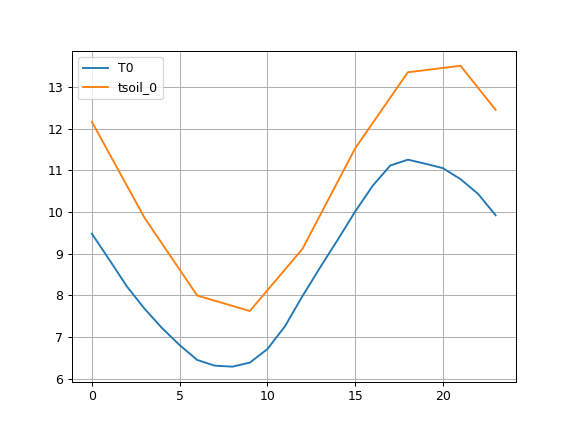

In [559]:

A = 'T0'
B = 'tsoil_0'

ax = axes[1,1]
Temp = GS[[A,B]].dropna()
Temp = Temp.groupby(Temp.index.hour).mean()
LR = stats.linregress(Temp[A],Temp[B])
print(LR)
fig,ax=plt.subplots()
Temp.plot(ax=ax)
ax.grid()




LinregressResult(slope=0.8034859538201982, intercept=11.975791357931215, rvalue=0.9874704001400941, pvalue=3.8853194298982994e-19, stderr=0.027375483468674158)


<IPython.core.display.Javascript object>


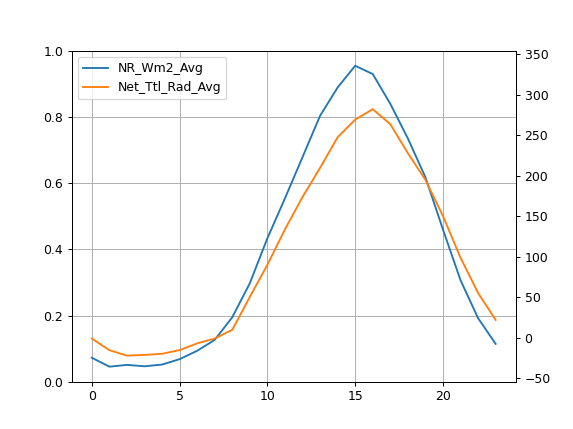

<IPython.core.display.Javascript object>


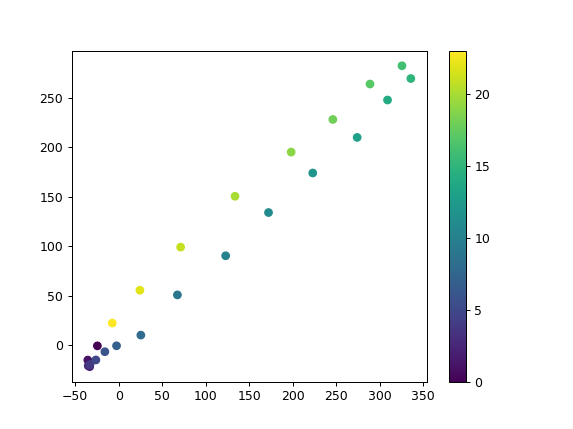

<IPython.core.display.Javascript object>


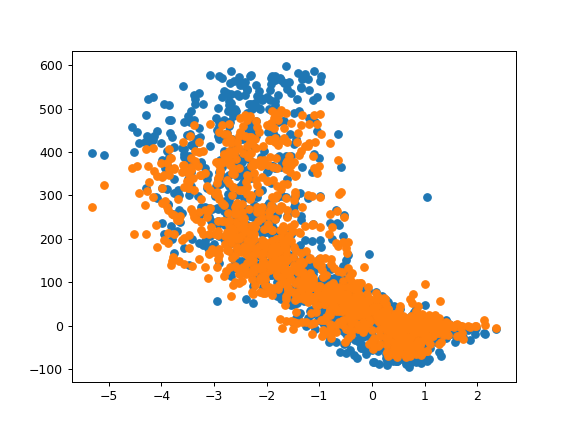

0.6138748327903523
0.6135732278728105


In [560]:

A = 'NR_Wm2_Avg'
B = 'Net_Ttl_Rad_Avg'


# A = 'VWC_2'
# B = 'SoilMoist(4)'
ax = axes[1,1]
Temp = GS[[A,B]].dropna()
# Temp = GS[[A,B,'Net_SW_Wm2_Avg', 'Net_LW_Wm2_Avg','fco2']].dropna()
Temp = Temp.groupby(Temp.index.hour).mean()
LR = stats.linregress(Temp[A],Temp[B])
print(LR)
fig,ax=plt.subplots()
# plt.plot(Temp[A],label='Fish Island')
# plt.plot(Temp[B],label='Taglu')
ax2=ax.twinx()
Temp.plot(ax=ax2)
# (-1*Temp['fco2']).plot(ax=ax,color='k')
ax.grid()



plt.legend()

plt.figure()
plt.scatter(Temp[A],Temp[B],c=Temp.index)
plt.colorbar()


plt.figure()
Temp = GS[[A,B,'fco2']].dropna()
LR = stats.linregress(Temp[A],Temp['fco2'])
print(LR[2]**2)
LR = stats.linregress(Temp[B],Temp['fco2'])
print(LR[2]**2)
plt.scatter(GS['fco2'],GS[A])
plt.scatter(GS['fco2'],GS[B])

      Rainfall_Tot        apcp
2009           5.1   47.088555
2010          87.2   95.985007
2011          28.3   30.614029
2012          89.7   65.388954
2013         107.4  103.441250
2014          70.5   83.714288
2015         127.6  120.768302
2016          56.6   65.533591
2017         111.5  134.679718
2018         105.4  106.645375


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>


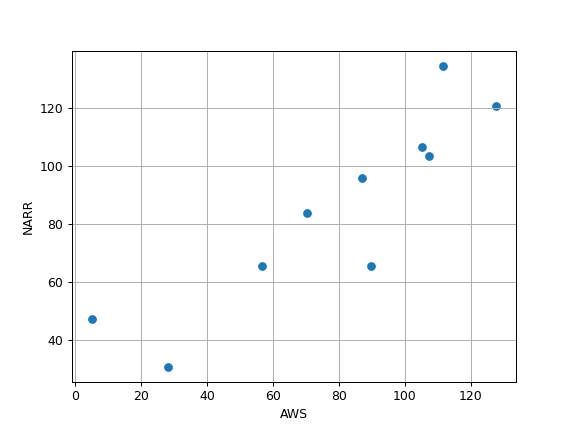

<IPython.core.display.Javascript object>


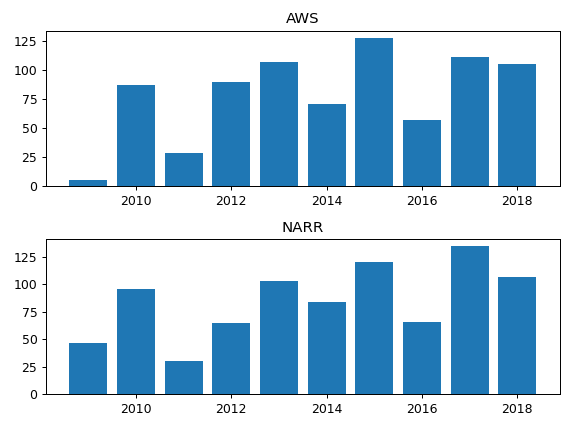

In [573]:
# print(Comp.dfNARR.columns)
GS['NR']=-GS[['ulwrf', 'uswrf']].sum(axis=1)+GS[['dlwrf', 'dswrf']].sum(axis=1)
# plt.figure()
# plt
# print(GS['NR'])

A = 'Rainfall_Tot'
B = 'apcp'
print(YearS[[A,B]])
fig,ax=plt.subplots()
ax.scatter(YearS[A],YearS[B])
ax.set_ylabel('NARR')
ax.set_xlabel('AWS')
ax.grid()

fig,ax=plt.subplots(2)
ax[0].bar(YearS.index,YearS[A])
ax[0].set_title('AWS')
ax[1].bar(YearS.index,YearS[B])
ax[1].set_title('NARR')
plt.tight_layout()

<IPython.core.display.Javascript object>


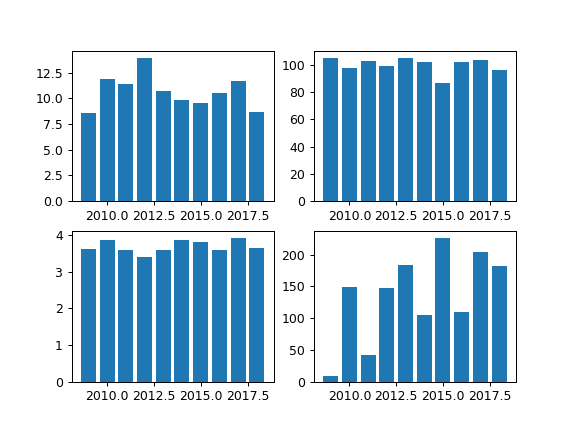

      Rain_mm_Tot  Rainfall_Tot        apcp
MT                                         
2009          0.0           9.1  278.985930
2010          0.0         148.6  429.514793
2011          0.0          42.4  101.012770
2012          0.0         148.2  272.035156
2013          0.0         183.8  473.433495
2014          0.0         105.0  366.989456
2015          0.0         225.4  540.222588
2016          0.0         109.1  328.448620
2017         91.4         203.4  699.818341
2018          0.0         182.7  529.305970


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
# Temp2 = Temp.loc[((Temp.DOY>Comp.Data['DOY'].min())&(Temp.DOY<Comp.Data['DOY'].max()))].groupby([Temp.Year]).mean()

# print(GS) 
#                        (Comp.AllData.index.dayofyear>Comp.Data['DOY'].min())&(Comp.AllData.index.dayofyear<Comp.Data['DOY'].max()))]
# print(GS)



# print(Year['AirTemp_Avg'].rank(ascending=False))
# print(Year['Net_Ttl_Rad_Avg'].rank(ascending=False))
# print(YearS[['Rainfall_Tot','apcp']].rank(ascending=False))
print(YearS[['Rain_mm_Tot','Rainfall_Tot','apcp']])
# # print(YearS[].rank(ascending=False))
# # apcp
# print(Year['WindSpd'].rank(ascending=False))
# # print(GS[''])
# print(Comp.dfTaglu.columns)
# print(Comp.dfNARR.columns)

July_Aug = 15.6+85.4


fig=plt.figure()
O9 = GS.loc[GS.index.year==2009].resample('D').sum()
# print(O9['apcp'])
plt.bar(O9.index,O9['apcp'])
plt.bar(O9.index,O9['Rainfall_Tot'])
fig.autofmt_xdate()


fig=plt.figure()
O9 = GS.loc[GS.index.year==2017].resample('D').sum()
# print(O9['apcp'])
plt.bar(O9.index,O9['apcp'])
plt.bar(O9.index,O9['Rainfall_Tot'])
plt.bar(O9.index,O9['Rain_mm_Tot'])
fig.autofmt_xdate()




3.8434979535264207
30.3002839257616
215.0 215.0
Year
2016    3.621371
2011    3.623359
2012    3.625363
2013    3.651343
2009    3.676233
2010    3.705266
2018    3.738529
2015    3.817868
2017    3.836694
2014    3.962418
Name: WindSpd, dtype: float64
Year
2018     7.516084
2009     8.053593
2015     9.002057
2014     9.055706
2013     9.754666
2016     9.906587
2011    10.350441
2017    10.689248
2010    10.960386
2012    12.957635
Name: AirTemp, dtype: float64
Year
2009    0.002623
2011    0.014558
2016    0.034439
2014    0.036265
2010    0.044856
2012    0.046142
2018    0.054218
2013    0.055247
2017    0.057356
2015    0.065638
Name: Rainfall_Tot, dtype: float64
                           RECORD  AirTemp  AirTemp_Avg  Rainfall_Tot  \
datetime                                                                
2008-08-27 13:00:00-06:00    17.0   6.4780       6.5240           0.0   
2008-08-27 13:30:00-06:00    17.5   6.5005       6.4865           0.0   
2008-08-27 14:00:00-06:00    1

<IPython.core.display.Javascript object>


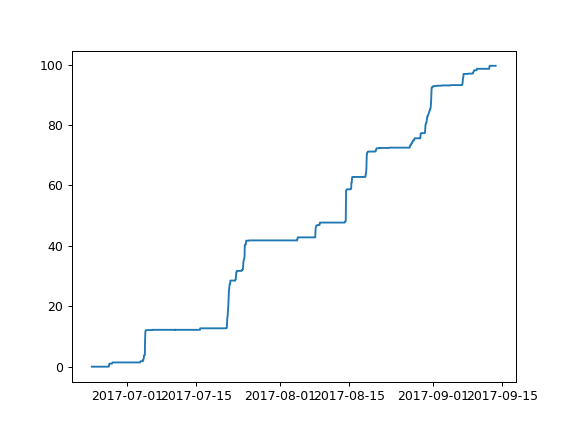

6     1.4
7    40.4
8    51.0
9     6.8
Name: Rain_mm_Tot, dtype: float64
-8.49963252547252


In [2]:

Temp = Comp.dfTaglu.copy()
Temp['Month'] = Comp.dfTaglu.index.month
Temp['Year'] = Comp.dfTaglu.index.year
Temp['DOY'] = Comp.dfTaglu.index.dayofyear
Comp.Data['DOY'] = Comp.Data.index.dayofyear
Comp.Data['Month'] = Comp.Data.index.month

print(Comp.Data['wind_speed'].mean())#*3600*1e-3)
print(Comp.Data['max_wind_speed'].max())#*3600*1e-3)
Temp = Temp.loc[((Temp.Year>2008)&(Temp.Year<2019))]

# print()
# Temp3 = Comp.Data.loc[((Comp.Data.Month==7)|
#                   (Comp.Data.Month==8))].mean()
#

# []
Temp2 = Temp.loc[((Temp.DOY>Comp.Data['DOY'].min())&(Temp.DOY<Comp.Data['DOY'].max()))].groupby([Temp.Year]).mean()

print(Temp2['DOY'].min(),Temp2['DOY'].max())

print(Temp2['WindSpd'].sort_values())
print(Temp2['AirTemp'].sort_values())
print(Temp2['Rainfall_Tot'].sort_values())
print(Comp.dfTaglu.head())


# Temp3 = Comp.Data.loc[((Comp.Data.Month==7)|
#                   (Comp.Data.Month==8))].mean()
# print(Temp3['wind_speed'])

plt.figure()
plt.plot(Comp.Data['Rain_mm_Tot'].cumsum())


print(Comp.Data.groupby(Comp.Data.index.month).sum()['Rain_mm_Tot'])



datetime
1     3.969436
2     4.012603
3     3.711906
4     4.068017
5     4.114678
6     3.983486
7     3.734835
8     3.617669
9     3.673978
10    3.478187
11    3.609169
12    3.621706
Name: WindSpd, dtype: float64
6    4.649017
7    4.153029
8    3.617582
9    3.165464
Name: wind_speed, dtype: float64


<IPython.core.display.Javascript object>


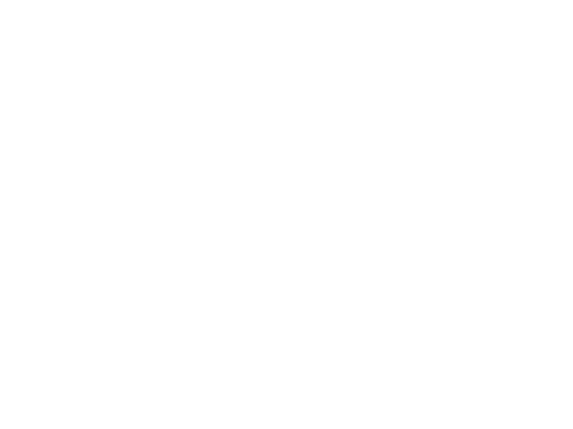

AttributeError: 'Int64Index' object has no attribute 'hour'

In [5]:


plt.figure()
Temp = Temp.groupby(Temp.index.hour).mean()
plt.plot(Temp['Net_Ttl_Rad_Avg'])
Temp = Comp.dfTaglu.loc[Comp.dfTaglu.index.month==2]
Temp = Temp.groupby(Temp.index.hour).mean()
plt.plot(Temp['Net_Ttl_Rad_Avg'])



# Comp.dfNARR['MT'] = Comp.dfNARR.index.tz_localize(pvytz.utc).tz_convert()
# Comp.dfTaglu.index.tz_localize(Comp.Mt,ambiguous=True,nonexistent='NaT')
# [Comp.Mt.localize(I).astimezone(pytz.utc) for I in Comp.dfTaglu.index]
# import pytz
# # Comp.dfNARR['MT'] = Comp.dfNARR.index.tz_localize(pytz.utc).tz_convert(pytz.timezone('US/Mountain'))
# Comp.Data['UTC'].values
# print(Comp.dfNARR)
# plt.figure()
# print(Comp.Data['Net_Ttl_Rad_Avg'])
Comp.Data['dNR']=Comp.Data[['dlwrf','dswrf']].sum(axis=1)

Comp.Data['uNR']=-Comp.Data[['ulwrf','uswrf']].sum(axis=1)
# plt.plot(Comp.Data['NR'])
# plt.plot(Comp.Data['Net_Ttl_Rad_Avg'])
# plt.plot(Comp.Data['NR_Wm2_Avg'])

# Temp = Comp.Data[['NR','Net_Ttl_Rad_Avg','NR_Wm2_Avg']].dropna()
# # print(Temp)
# plt.figure()
# plt.scatter(Temp['NR_Wm2_Avg'],Temp['NR'])
Comp.Data.Time=Comp.Data.index.hour
Temp = Comp.Data.groupby('Time').mean()[['dNR','uNR','Net_Ttl_Rad_Avg','NR_Wm2_Avg']]

plt.figure()
# plt.plot()
plt.plot(Temp['uNR']+Temp['dNR'])
plt.plot(Temp['Net_Ttl_Rad_Avg'])
plt.plot(Temp['NR_Wm2_Avg'])
plt.grid()
# print(Comp.Data['UTC'][:60])

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)

# print(Comp)
V = 'PPFD_Avg'
Inputs = ['TOD','DOY','ulwrf', 'dlwrf', 'dswrf', 'uswrf','pres','tcdc']
AllPuts=Inputs.copy()
AllPuts.append(V)
Temp = Comp.Data[AllPuts].dropna()

X = Temp[Inputs].values
y = Temp[V].values


kf.get_n_splits(X)

# print(kf)
Comp.AllData['DOY']=Comp.AllData.index.dayofyear
KF = []
KF_All = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = RandomForestRegressor(max_depth=10, random_state=0)
    regr.fit(X_train, y_train)
    KF.append(regr.predict(Comp.Data[Inputs]))
    KF_All.append(regr.predict(Comp.AllData[Inputs]))
    print(regr.score(X_test,y_test))
    print(regr.feature_importances_)
Comp.Data[V+'_Modeled']=np.array(KF).mean(axis=0)
Comp.AllData[V+'_Modeled']=np.array(KF_All).mean(axis=0)
plt.figure()
plt.plot(Comp.Data[V+'_Modeled'])

# print(np.array(KF).mean(axis=0).shape)



NameError: name 'Comp' is not defined

<IPython.core.display.Javascript object>


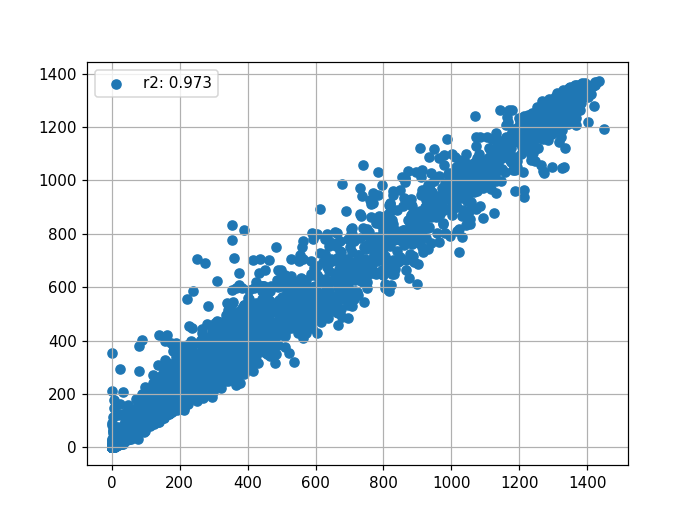

LinregressResult(slope=0.9431720262991768, intercept=19.218694353500666, rvalue=0.9862447422222073, pvalue=0.0, stderr=0.0025231154739680946)


<IPython.core.display.Javascript object>

No handles with labels found to put in legend.


datetime
2017-06-23 15:00:00    0.258591
2017-06-23 15:30:00    0.258439
2017-06-23 16:00:00    0.258287
2017-06-23 16:30:00    0.258135
2017-06-23 17:00:00    0.257983
                         ...   
2017-09-13 10:30:00    0.303680
2017-09-13 11:00:00    0.303705
2017-09-13 11:30:00    0.303731
2017-09-13 12:00:00    0.303757
2017-09-13 12:30:00    0.303784
Freq: 30T, Name: soill_10, Length: 3932, dtype: float64 datetime
2017-06-23 15:00:00    78.350
2017-06-23 15:30:00    78.185
2017-06-23 16:00:00    78.020
2017-06-23 16:30:00    77.885
2017-06-23 17:00:00    77.750
                        ...  
2017-09-13 10:30:00    85.800
2017-09-13 11:00:00    85.800
2017-09-13 11:30:00    85.800
2017-09-13 12:00:00    85.800
2017-09-13 12:30:00    85.800
Freq: 30T, Name: SoilMoist(4), Length: 3932, dtype: float64


<IPython.core.display.Javascript object>

In [26]:
from scipy.stats import stats
plt.figure()
Temp = Comp.AllData[['PPFD_Avg','PPFD_Avg_Modeled']].dropna()
LR = stats.linregress(Temp['PPFD_Avg'],Temp['PPFD_Avg_Modeled'])
print(LR)
plt.scatter(Comp.AllData['PPFD_Avg'],Comp.AllData['PPFD_Avg_Modeled'],label='r2: '+str(np.round(LR[2]**2,3)))
plt.legend()
plt.grid()


In [8]:

Comp.Data.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/AllData.csv')
Comp.AllData.to_csv('C:/Users/wesle/NetworkAnalysis/FishIsland/FullDataset.csv')
# else:

[[1.         0.96186736]
 [0.96186736 1.        ]]
-2.098242356254585e-16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


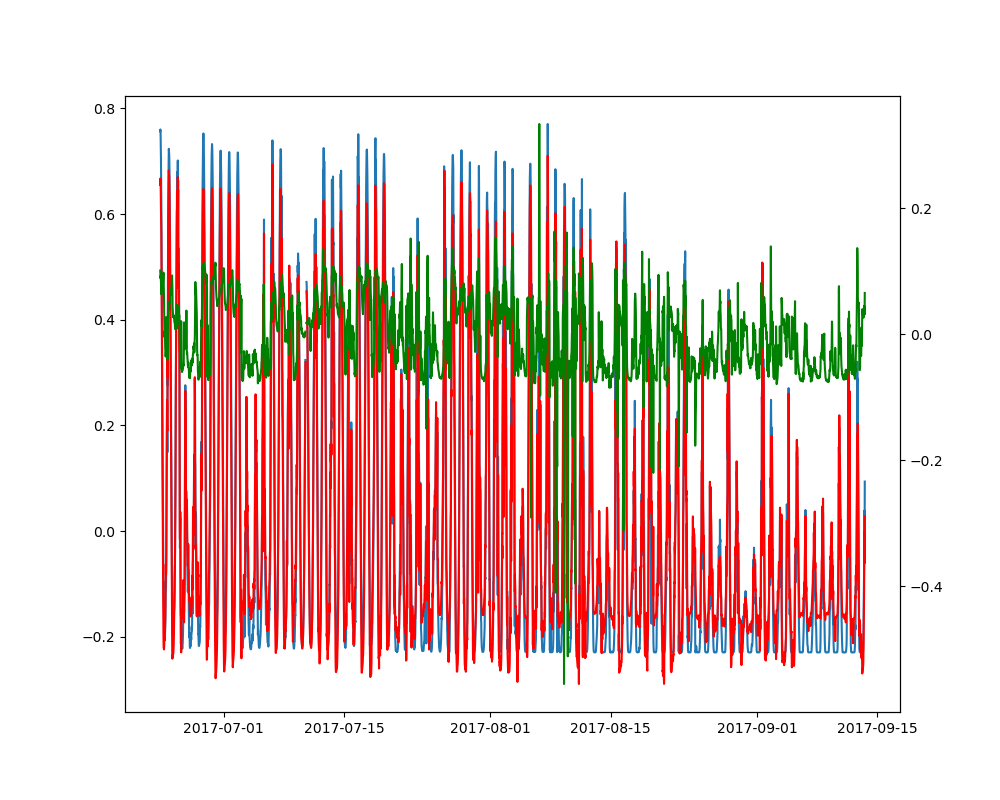

In [74]:
Temp = Data[['PPFD_Avg','NR_Wm2_Avg']].dropna()
print(np.corrcoef(Temp['PPFD_Avg'],Temp['NR_Wm2_Avg'])**2)
# Temp = Data.copy()
print(((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())-\
            (Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min())).mean())
# print((Data['PPFD_Avg']-Data['PPFD_Avg'].min())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())
plt.figure()
plt.scatter((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())-\
            (Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min()),
            Data['co2_flux'],
           c = Data['H'],
           s=4)
plt.colorbar()
plt.xlim(-.15,.15)
Temp = Data.loc[Data['co2_flux']>0]
plt.figure()
plt.scatter(Temp['co2_flux'],
            Temp['NR_Wm2_Avg'],
            c=Temp['PPFD_Avg'],
           s=4)
plt.colorbar()

plt.figure(figsize=(10,8))
# plt.plot(Data['PPFD_Avg'])


plt.plot((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min()))
plt.plot((Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min()),c='r')

x2=plt.twinx()
x2.plot(((Data['PPFD_Avg']-Data['PPFD_Avg'].mean())/(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())-\
            (Data['NR_Wm2_Avg']-Data['NR_Wm2_Avg'].mean())/(Data['NR_Wm2_Avg'].max()-Data['NR_Wm2_Avg'].min())),c='g')

# # plt.plot(Data['VWC_1'])


# print(Data['SoilMoist(4)'].count())
# print(Data['SoilMoist(1)'].count())

<IPython.core.display.Javascript object>


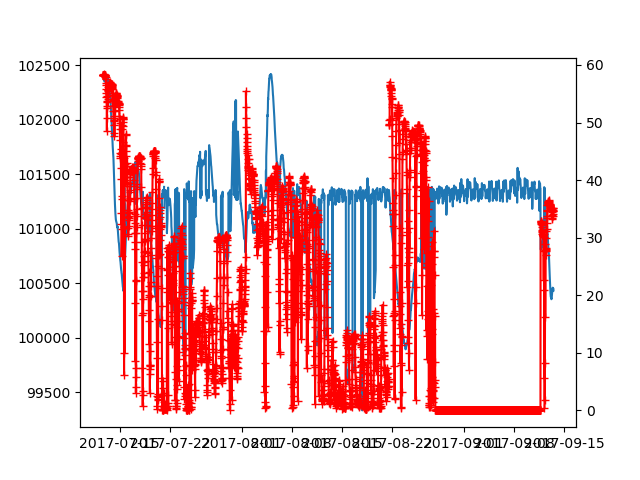

<IPython.core.display.Javascript object>


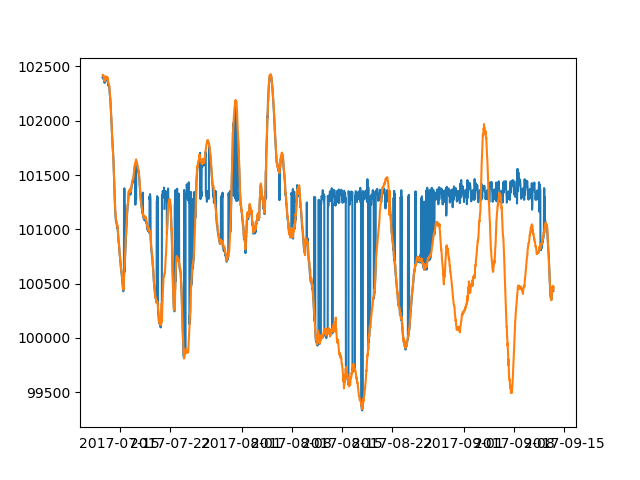

In [29]:
# plt.figure()
# plt.plot(Temp['co2_flux'])
# plt.plot(Data['co2_flux'])
# # plt.plot(Temp)

# plt.figure(figsize = (8,7))
# plt.plot(Temp['ch4_flux'])
# plt.plot(Data['ch4_flux'])#,marker = '+')
# # Temp2 = Data.copy()


# print(Data['co2_flux'].mean())
# print(Temp.mean())


# print(Data['co2_flux'].count())
# print(Temp.count())

# print(Data['ch4_flux'].mean())
# print(Temp2.mean())


# print(Data['ch4_flux'].count())
# print(Temp2.count())



FluxFolder='FluxResults/Pressure_Fix/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2020-07-06T150723_exp.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2020-07-03T202612_exp.csv'


Nu = pd.read_csv(TenHz_Path,
                  delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999)
Nu = Nu.iloc[1:]
Nu = Nu.set_index(pd.DatetimeIndex(Nu.datetime))
Nu[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']] = Nu[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']].astype(float)

FluxFolder='FluxResults/ProperWindSpeeds/'

TenHz_Path = Root+FluxFolder+'10Hz/eddypro_10Hz_full_output_2018-03-25T172145_adv.csv'
OneHz_Path = Root+FluxFolder+'1Hz/eddypro_1Hz_full_output_2018-03-25T142146_adv.csv'

Old = pd.read_csv(TenHz_Path,
                  delimiter = ',',skiprows = 0,parse_dates={'datetime':[1,2]},header = 1,na_values = -9999)
Old = Old.iloc[1:]
Old = Old.set_index(pd.DatetimeIndex(Old.datetime))
Old[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']] = Old[['ch4_flux','co2_flux','air_pressure','rssi_77_mean']].astype(float)
# plt.figure()
# plt.scatter(Nu['ch4_flux'].values,Old['ch4_flux'].values)



plt.figure()
# plt.plot(Nu['air_pressure']-Old['air_pressure'])
plt.plot(Old['air_pressure'])

# plt.plot(Old['ch4_flux']*0+Old['air_pressure'].mean(),marker='+',color='red')
plt.twinx()
plt.plot(Old['rssi_77_mean'],marker='+',color='red')

# plt.figure()
# plt.scatter(Nu['co2_flux'].values,Old['co2_flux'].values)

# plt.figure()
# plt.scatter(Nu['air_pressure'].values,Old['air_pressure'].values)

# print(Nu['ch4_flux'].mean(),Old['ch4_flux'].mean())


# print(Nu['ch4_flux'].shape,Old['ch4_flux'].shape)


# plt.figure()


# plt.scatter(Nu.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])<50,'co2_flux'],
#          Old.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])<50,'co2_flux'])
# plt.scatter(Nu.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])>50,'co2_flux'],
#          Old.loc[np.abs(Nu['air_pressure']-Old['air_pressure'])>50,'co2_flux'])

plt.figure()
# plt.plot(Nu['air_pressure']-Old['air_pressure'])
plt.plot(Old['air_pressure'])
plt.plot(Nu['air_pressure'])
# plt.yscale('symlog')

<IPython.core.display.Javascript object>


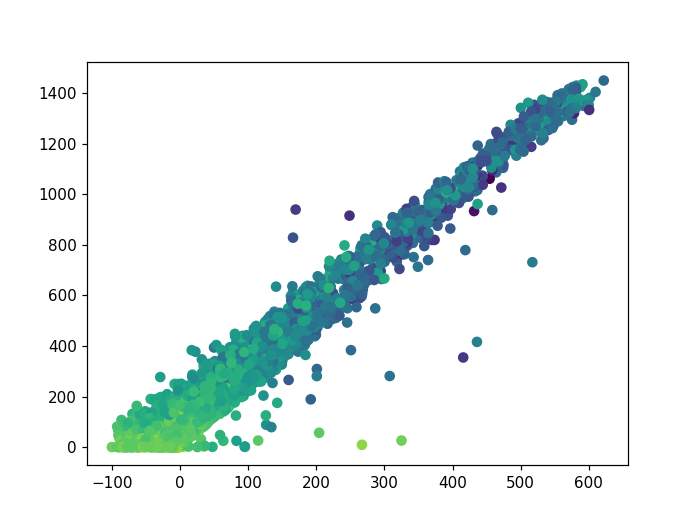

In [62]:
plt.figure()
plt.scatter(Data['NR_Wm2_Avg'],Data['PPFD_Avg'],c=Data['co2_flux'])
# x2=plt.twinx()
# x2.plot(Data['u*'],color='orange')

In [ ]:


from scipy.stats import pearsonr
plt.figure()
plt.scatter(Data['fch4']*1e-3 * 12.0107 *3600*24,Data['rssi_77_mean'])
print(Data['fch4'].mean()*1e-3 * 12.0107 *3600*24)

Temp = Data[['fch4','rssi_77_mean']].dropna()

# Temp = Temp.loc[Temp['rssi_77_mean']>20]
S,_ = pearsonr(Temp['fch4'].values,Temp['rssi_77_mean'].values)
print(S)

In [ ]:
# plt.figure()
# # Data.loc[((Data.index>'2017-7-10 12:00:00')&((Data.index<'2017-7-10 19:30:00'))),['Table_1','Table_2','Table_3',]]=np.nan
# # Data.loc[((Data.index>'2017-8-1 14:00:00')&((Data.index<'2017-8-1 22:00:00'))),['Table_1','Table_2','Table_3',]]=np.nan
# plt.plot(Data['Table_1'])
# # plt.plot(Data['Table_2'])
# # plt.plot(Data['Table_3'])
# x2=plt.twinx()
# x2.plot(Data['Total_Rain_mm_Tot'],c='g')
# before = Data.loc[((Data.index<'2017-7-10 12:00:00')&((Data.index>'2017-7-10 6:00:00'))),['Depth_3']].mean()
# after = Data.loc[((Data.index>'2017-7-10 14:30:00')&((Data.index<'2017-7-10 19:30:00'))),['Depth_3']].mean()
# print(after - before)

# '2017-8-1 15:00:00'
# before = Data.loc[((Data.index<'2017-8-1 14:00:00')&((Data.index>'2017-8-1 8:00:00'))),['Depth_3']].mean()
# after = Data.loc[((Data.index>'2017-8-1 16:00:00')&((Data.index<'2017-8-1 22:00:00'))),['Depth_3']].mean()
# print(after - before)

plt.figure()
# plt.scatter(Data['H'],Data['NR_Wm2_Avg'])
plt.scatter(Data['NR_Wm2_Avg'],Data['Net_Ttl_Rad_Avg'])
Temp = Data.loc[((np.isnan(Data['NR_Wm2_Avg'])==False)&(np.isnan(Data['Net_Ttl_Rad_Avg'])==False))]
print(metrics.r2_score(Temp['NR_Wm2_Avg'],Temp['Net_Ttl_Rad_Avg']))
def Curve(x,a,b):
    return(a*x+b)
p,r=curve_fit(Curve,Temp['Net_Ttl_Rad_Avg'],Temp['NR_Wm2_Avg'])
print(p)

In [ ]:

def AL(AL,a,b,c,d):
#     cv =.7
    return(a*AL**3+b*AL**2+AL*c+d)
#     return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))

from scipy.optimize import minimize, curve_fit


Comp.Data['DOY']=Comp.Data.index.dayofyear
Temp = Comp.Data[['Active_Layer_1','DOY']].resample('D').mean().round(2)
print(Temp.loc[Temp['Active_Layer_1']==.4])

popt_r, pcov = curve_fit(AL, Temp['Active_Layer_1'], Temp['DOY'])

plt.figure(figsize =(10,7))
plt.plot(np.arange(0,1,.05),AL(np.arange(0,1,.05),*popt_r))#*-1*100)
plt.scatter(Temp.Active_Layer_1,Temp['DOY'])
plt.grid()
plt.ylim(Temp['DOY'].min()-15,Temp['DOY'].max()+15)
plt.xlim(Temp['Active_Layer_1'].min()-.1,Temp['Active_Layer_1'].max()+.1)

print(AL(.0,*popt_r))
print(AL(.2,*popt_r))
print(AL(.3,*popt_r))

In [ ]:
plt.figure()
plt.plot(Data['Temp_2_5_2'])
plt.plot(Data['Temp_5_2'])
# plt.plot(Data['Temp_2_5_2'])
plt.plot(Data['Temp_15_2'])
# plt.plot(Data['Temp_5_2'])
plt.figure()
plt.scatter(Data['Temp_15_1'],Data['Temp_15_2'])
# ,'Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2'])

# plt.figure()
# plt.plot()
m = (Data['Temp_15_1'].mean()-Data['Temp_5_1'].mean())/10
Data['m'] = (Data['Temp_15_1']-Data['Temp_5_1'])/10
print(m)
X = np.arange(0,30)
b=(Data['Temp_5_1'].mean()-m*5)
print(b)
Data['b']=Data['Temp_5_1']-Temp['m']*5

# y = mx+b
# mx=y-b
# x=(y-b)/m
# y = m*X+b
plt.figure()
plt.plot((0-Data['b'])/Data['m'])
# plt.plot(X,y)
# plt.scatter(2.5,Data['Temp_2_5_1'].mean())
# plt.scatter(5,Data['Temp_5_1'].mean())
# plt.scatter(15,Data['Temp_15_1'].mean())

In [ ]:
def Curve(X,b,c):#,c,d):
    return(b*X+c)

#     return(-np.tanh(a*X+b)*c+d)
# def Curve(X,b):
#     return((b/X-10))
Y = np.array([[10,8,2],[10,8,3]])
plt.figure()
i = 0
Zp = []
Temp = Data[['Temp_2_5_2','Temp_5_2','Temp_15_2','Active_Layer_2']]#.resample('D').mean()
# print(Temp)
F = []
for d in Data.DOY.unique():
    y = Data.loc[Data.DOY==d,['Temp_2_5_1','Temp_5_1','Temp_15_1']].values#.flatten()
    X = np.array([np.array([2.5,5,15])for x in range(y.shape[0])]).flatten()
    y=y.flatten()
    try:
        p,z = curve_fit(Curve,X,y)
        z = np.arange(0,60)
        plt.plot(z,Curve(z,*p))
        plt.scatter(X,y)
        
        F.append(z[np.where(Curve(z,*p)<=-1)][0])
    except:
        pass
# Zp = np.array(Zp)
F = np.array(F)

# print(np.mean(F))
# print(np.std(F))

In [ ]:

plt.figure()
plt.plot(F)
plt.plot(Data['Active_Layer_1'].resample('D').mean().values*100)

In [ ]:

# def y(X,a=1,b=1,c=1,d=1):
# #     return(a*X**2+b*X+c)
# #     return(a*X**2+b*X+c)
#     return((a)**2*X**2+b*X+c)
#     return(-np.tanh(a*X+b)*c+d)
plt.figure()
plt.plot(Data['VWC_1'])
# plt.plot(Data['VWC_2'])
x2 = plt.twinx()
x2.plot(Data['Table_1'],color='g')
x2.plot(Data['Table_3'],color='y')
x2.plot(Data['Table_2'],color='r')